**Table of contents**<a id='toc0_'></a>    
- 1. [Giới thiệu về hướng triển khai](#toc1_)    
- 2. [Hàm tiện ích](#toc2_)    
  - 2.1. [Hàm pipelines xử lý dữ liệu](#toc2_1_)    
    - 2.1.1. [Thao tác file](#toc2_1_1_)    
    - 2.1.2. [Tạo đặc trưng](#toc2_1_2_)    
  - 2.2. [Một số utils khác](#toc2_2_)    
  - 2.3. [Data Augmentation](#toc2_3_)    
- 3. [Xử lý data](#toc3_)    
  - 3.1. [Tạo features](#toc3_1_)    
  - 3.2. [Chia train-test](#toc3_2_)    
  - 3.3. [Điều chỉnh nhãn](#toc3_3_)    
- 4. [Huấn luyện mô hình](#toc4_)    
  - 4.1. [Setup hyper-parameters](#toc4_1_)    
  - 4.2. [Huấn luyện (fit)](#toc4_2_)    
  - 4.3. [Dự đoán trên tập test](#toc4_3_)    
  - 4.4. [Đánh giá](#toc4_4_)    
- 5. [Xuất](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[Giới thiệu về hướng triển khai](#toc0_)

- Mục tiêu: tìm hiểu mô hình và xác lập kỳ vọng
  
- Mô hình sử dụng: <strong>LightGBM</strong>

- Quy trình thực hiện:

    - <strong>(✓) 0.</strong> Chuẩn bị dữ liệu (extinct Flux)
    - <strong>1.1 Features Engineering</strong>, cụ thể gồm:
        - <strong>(✓)</strong> Liên quan tới thống kê: mean, min-max, std, var, skewness, kurtosis, skewness
        - Liên quan tới vật lý: Abs_Flux = mean_flux * (1 + Z)
        - Một số đặc trưng khác muốn điều tra độ hiệu quả: weight, liên quan chuỗi thời gian
    - <strong>1.2</strong> Tối ưu việc sử dụng dataset - <strong>data augmentation</strong> (bằng cách tận dụng chia nhỏ split của 1 object để tăng số lượng input)
        - <strong>(✓)</strong> Theo hướng <strong>sampling</strong>: lấy mẫu ngẫu nhiên <strong>without replacement</strong> (no duplicate time-filter)
        - <strong>(✓)</strong> Theo hướng <strong>sliding-window</strong>: lấy một cụm dữ liệu split liên tiếp với nhau (theo trục thời gian)
    - <strong>(✓) 2</strong> Xử lý data
    - <strong>(✓) 3</strong> Xây dụng model
    - <strong>(✓) 4</strong> Thử nghiệm và đánh giá model (chưa tuning)

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os.path as path

from typing import Callable

pd.set_option('display.max_columns', None)

# Preparation for correct Flux (explain later)
# !pip -q install extinction==0.4.7
from extinction import fitzpatrick99
WAVELENGTHS = { ## sourced from SVO Filter Profile Service
    'u': 3641,
    'g': 4704,
    'r': 6155,
    'i': 7504,
    'z': 8695,
    'y': 10056
}


## Chuẩn bị dir (để truy cập file khi cần)
dirname = {
    'root': './kaggle/input', # input dir
    'working': './kaggle/working/',   # current session's saving file dir
}
train_sp_name = 'train_full_lightcurves.csv'
test_sp_name = 'test_full_lightcurves.csv'


## Tải train_log
train_log = pd.read_csv(
    path.join( dirname['root'], 'train_log.csv' )) # ví dụ load file

train_log = train_log.drop(['English Translation', 'target'], axis=1) # lọc cột thừa 
train_log['Z_err'] = train_log['Z_err'].fillna(0)

## Tải test_log



In [3]:
train_log.head(3)


,object_id,Z,Z_err,EBV,SpecType,split
0,Dornhoth_fervain_onodrim,3.0490,0.0,0.110,AGN,split_01
1,Dornhoth_galadh_ylf,0.4324,0.0,0.058,SN II,split_01
2,Elrim_melethril_thul,0.4673,0.0,0.577,AGN,split_01


# 2. <a id='toc2_'></a>[Hàm tiện ích](#toc0_)

In [4]:
sample_log = train_log[train_log['object_id'].isin(['amon_imloth_luin', 'cirion_ira_Ithil', 'cuin_haudh_cenedril']) ]
sample_log

,object_id,Z,Z_err,EBV,SpecType,split
12,amon_imloth_luin,0.7766,0.0,0.055,TDE,split_01
27,cirion_ira_Ithil,0.3325,0.0,0.023,SN Ia,split_01
30,cuin_haudh_cenedril,0.5366,0.0,0.013,AGN,split_01


## 2.1. <a id='toc2_1_'></a>[Hàm pipelines xử lý dữ liệu](#toc0_)


### 2.1.1. <a id='toc2_1_1_'></a>[Thao tác file](#toc0_)

- <strong>join_DataFrame (<i> df_log, df_split </i>)</strong> : liên kết log và split thành một bảng thống nhất

- <strong>jurassic_park (<i> row </i>)</strong> : hàm chỉnh sửa Flux (dust EBV extinction)

- <strong>process_and_combine_splits (<i> df_log, on_file, callback_func </i>)</strong> : đọc log và tự tìm đến file split tương ứng (dựa theo tên <i>on_file</i>)

- <strong>basic_process(<i> df_log, df_split </i>)</strong> : một đầu vào khả thi cho call_func của <strong><i>process_and_combine_splits</i></strong>, thực hiện join 2 DataFrame và khử Flux

In [5]:
from scipy import stats, integrate

# Hằng số vũ trụ học (Planck 2018)
H0 = 67.4       
Om0 = 0.315    
CLIGHT = 299792.458

def jurassic_park(df:pd.DataFrame):
    """
    Áp dụng hiệu chỉnh tuyệt chủng (Extinction Correction) vector hóa.
    Đầu vào: DataFrame chứa cột 'Flux', 'Flux_err', 'Filter', 'EBV'.
    Đầu ra: DataFrame đã cập nhật Flux và Flux_err.
    """

    # 2. Tính hệ số R_lambda cho từng Filter
    # A_lambda = fitzpatrick99(wave, Rv * EBV)
    # Ta tính trước A_lambda tại EBV=1 và Rv=3.1 để ra hệ số cố định cho mỗi filter
    # Vì hàm fitzpatrick99 thường nhận numpy array bước sóng (Angstrom)
    
    extinction_coeffs = {}
    for flt, wave in WAVELENGTHS.items():
        # Gọi hàm fitzpatrick99 với 1 giá trị bước sóng, Rv=3.1 (Milky Way), giả định EBV=1 để lấy hệ số
        # Lưu ý: fitzpatrick99 thường yêu cầu input là mảng numpy
        try:
            # Code này tùy thuộc vào implementation của fitzpatrick99 mà bạn đang dùng
            # Kết quả trả về là độ giảm Magnitude cho EBV=1
            coeff = fitzpatrick99(np.array([wave]), 3.1)[0] 
        except:
            # Fallback nếu hàm fitzpatrick99 của bạn có cú pháp khác
            # Đây là logic: A_lambda = Coeff * EBV
            pass 
        extinction_coeffs[flt] = coeff

    # 3. Map hệ số vào DataFrame
    # Tạo cột tạm chứa hệ số R tương ứng với Filter của dòng đó
    df['ext_coeff'] = df['Filter'].map(extinction_coeffs)

    # 4. Tính Scale Factor: 10^(A_lambda / 2.5)
    # A_lambda_thuc_te = ext_coeff * EBV
    df['scale_factor'] = 10 ** ((df['ext_coeff'] * df['EBV']) / 2.5)

    # 5. Áp dụng hiệu chỉnh cho cả Flux và Flux_err
    df['Flux'] = df['Flux'] * df['scale_factor']
    df['Flux_err'] = df['Flux_err'] * df['scale_factor']

    # 6. Dọn dẹp
    df.drop(columns=['ext_coeff', 'scale_factor'], inplace=True)
    
    return df

def get_luminosity_distance(z):
    """Tính khoảng cách độ chói (Luminosity Distance) theo Redshift."""
    if z <= 0: return 0
    inv_E = lambda x: 1.0 / np.sqrt(Om0 * (1 + x)**3 + (1 - Om0))
    dc, _ = integrate.quad(inv_E, 0, z)
    return (CLIGHT / H0) * dc * (1 + z)

def calculate_distance_modulus(z_array):
    """Vector hóa hoặc Map việc tính Distance Modulus."""
    unique_zs = np.unique(z_array)
    dist_map = {}
    for z in unique_zs:
        d_L_Mpc = get_luminosity_distance(z)
        if d_L_Mpc > 0:
            mu = 5 * np.log10(d_L_Mpc) + 25
        else:
            mu = np.nan
        dist_map[z] = mu
    return dist_map

def preprocess_lightcurves(df):
    """
    Ánh xạ Filter -> Bước sóng, tính Rest-frame và phân loại Bin.
    """
    df = jurassic_park(df)
    flux_col = 'Corrected Flux' if 'Corrected Flux' in df.columns else 'Flux'
    
    # 1. Physics Mapping (Filter -> Wavelength)
    # Lấy từ dict WAVELENGTHS toàn cục
    df['lambda_obs'] = df['Filter'].map(WAVELENGTHS)
    
    # 2. Tính Rest-frame Wavelength
    # lambda_rest = lambda_obs / (1 + z)
    df['lambda_rest'] = df['lambda_obs'] / (1 + df['Z'])
    
    # 3. Binning (Phân loại vùng năng lượng)
    # UV: < 3500 A | Optical: 3500-7000 A | IR: > 7000 A
    conditions = [
        (df['lambda_rest'] < 3500),
        (df['lambda_rest'] >= 3500) & (df['lambda_rest'] <= 7000),
        (df['lambda_rest'] > 7000)
    ]
    choices = ['UV', 'Optical', 'IR']
    df['Filter'] = np.select(conditions, choices, default='Optical')

    # 4. Magnitude & Luminosity (Giữ nguyên logic cũ)
    dist_map = calculate_distance_modulus(df['Z'].values)
    df['dist_mod'] = df['Z'].map(dist_map)
    
    m_apparent = np.full(len(df), np.nan)
    mask_pos = df[flux_col] > 0
    m_apparent[mask_pos] = -2.5 * np.log10(df.loc[mask_pos, flux_col]) + 23.9
    df['m_apparent'] = m_apparent
    df['M_abs'] = df['m_apparent'] - df['dist_mod']
    df['Log_Luminosity'] = -0.4 * df['M_abs']

    # 5. Time Normalization
    df = df.sort_values(by=['object_id', 'Time (MJD)'])
    t0 = df.groupby('object_id')['Time (MJD)'].transform('min')
    df['Time (MJD)'] = (df['Time (MJD)'] - t0) / (1 + df['Z'])
    
    return df.drop(['lambda_obs'], axis=1)


In [6]:
def join_DataFrame (df_log:pd.DataFrame, df_split:pd.DataFrame) :
    return pd.merge(
                left= df_log,          # Bảng 1 (Thông tin tĩnh - Left Table)
                right= df_split,    # Bảng 2 (Thông tin chuỗi thời gian - Right Table)
                on='object_id',          # Cột dùng để nối (Khóa chung)
                how='right'              # Loại phép nối: Right Join (Giữ tất cả dòng của Bảng 2)
        ).dropna()

def process_and_combine_splits(
    df_log: pd.DataFrame,
    on_file: str,
    callback_function: Callable[[pd.DataFrame, pd.DataFrame], pd.DataFrame]
) -> pd.DataFrame:
    """
    Nhóm DataFrame tĩnh theo cột 'split', đọc file CSV tương ứng,
    nối hai bảng, áp dụng hàm callback, và nối kết quả.

    Args:
        df_log: DataFrame gốc (Bảng 1) chứa thông tin 'split'.
        on_file: tên file trong folder split (test_full_lightcurves.csv hoặc train_full_lightcurves.csv)
        callback_function: Hàm (F) áp dụng lên 2 DataFrame sau khi được phân nhóm split, lần lượt là log_chunk và split
                eg: callback_function( df_log, df_split)
    Returns:
        DataFrame cuối cùng đã được nối và xử lý.
    """
    
    # 1. Nhóm DataFrame tĩnh theo cột 'split'
    grouped_logs = df_log.groupby('split')
    
    results_list = []

    # 2. Lặp qua từng nhóm
    for split_name, df_log_chunk in grouped_logs:
        # print(f"--- Đang xử lý nhóm: {split_name} ---")
        
        # 3a. Đọc file CSV (Bảng 2)
        df_split = pd.read_csv(
                path.join( dirname['root'], split_name, on_file ))
            
        # 3c. Áp dụng hàm callback (F)
        # Hàm F có thể thực hiện hiệu chỉnh Flux, merge 2 bảng,.. v.v.
        df_processed_chunk = callback_function(df_log_chunk, df_split, split_name)
        
        # Thêm kết quả đã xử lý vào danh sách
        results_list.append(df_processed_chunk)
        
        # print(f"Hoàn tất xử lý nhóm {split_name}. Kích thước: {len(df_processed_chunk)} dòng.")

    # 4. Nối toàn bộ sản phẩm của các group thành một DataFrame thống nhất
    if not results_list:
        return pd.DataFrame()
        
    final_df = pd.concat(results_list, ignore_index=True)
    
    return final_df

def basic_process(df_log:pd.DataFrame, df_split:pd.DataFrame, split_name:str) :
    df_full_join = join_DataFrame(df_log, df_split)

    df_prepocessed = preprocess_lightcurves(df_full_join)
    
    return df_prepocessed.drop(['Z_err', 'split'], axis = 1)
    


sample_log_raw = process_and_combine_splits(
    sample_log,
    'train_full_lightcurves.csv',
    basic_process
)

sample_log_single_object = sample_log_raw.groupby('object_id').get_group('amon_imloth_luin')

sample_log_raw

,object_id,Z,EBV,SpecType,Time (MJD),Flux,Flux_err,Filter,lambda_rest,dist_mod,m_apparent,M_abs,Log_Luminosity
0,amon_imloth_luin,0.7766,0.055,TDE,0.000000,-0.137194,0.301567,Optical,4894.179894,43.489552,NaN,NaN,NaN
1,amon_imloth_luin,0.7766,0.055,TDE,5.492908,-0.066016,0.174910,UV,3464.482720,43.489552,NaN,NaN,NaN
2,amon_imloth_luin,0.7766,0.055,TDE,6.866149,0.849852,0.943070,Optical,5660.249916,43.489552,24.076642,-19.412910,7.765164
3,amon_imloth_luin,0.7766,0.055,TDE,8.239390,-0.295371,0.910495,Optical,5660.249916,43.489552,NaN,NaN,NaN
4,amon_imloth_luin,0.7766,0.055,TDE,8.239390,-0.625070,0.536389,Optical,4894.179894,43.489552,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,cuin_haudh_cenedril,0.5366,0.013,AGN,1662.113107,0.108060,0.414702,UV,2369.517116,42.515961,26.315840,-16.200120,6.480048
430,cuin_haudh_cenedril,0.5366,0.013,AGN,1662.113107,0.106927,0.088131,UV,3061.304178,42.515961,26.327281,-16.188680,6.475472
431,cuin_haudh_cenedril,0.5366,0.013,AGN,1670.797084,0.084996,0.177624,Optical,4005.596772,42.515961,26.576502,-15.939459,6.375784
432,cuin_haudh_cenedril,0.5366,0.013,AGN,1670.797084,0.021165,0.186825,Optical,4883.509046,42.515961,28.085951,-14.430010,5.772004


### 2.1.2. <a id='toc2_1_2_'></a>[Tạo đặc trưng](#toc0_)

- <strong>extract_features_for_single_object ( <i>object_id, df_object </i>)</strong> : extract features cho một sample. Toàn bộ input được coi là phạm vi dữ liệu gốc để khai thác, tất cả được trả ra dưới tên là đặc trưng của object_id.

## 2.2. <a id='toc2_2_'></a>[Một số utils khác](#toc0_)

In [7]:
from typing import List
from sklearn.metrics import confusion_matrix

def score_prediction(ground_truth:pd.Series, prediction:List, labels:List, focus_label:str) :
    df_compare = pd.DataFrame({
        'True label' : ground_truth.values,
        'Prediction' : prediction
    }, index=ground_truth.index)
    confident = {}
    
    # Tính điểm từng label
    for label in labels :
        df_subset = df_compare[df_compare['True label'] == label]
        right = np.sum(df_subset['Prediction'] == label)
        total = len(df_subset)
        print(f'> {label} accuracy: {right}/{total}  ~ {(right/total * 100):.2f}%')
        confident[label] = right / total


    # Tính F1-score
    cm = confusion_matrix(df_compare['True label'] == focus_label, 
                          df_compare['Prediction'] == focus_label, 
                          labels=[False, True])
    TN, FP, FN, TP = cm.ravel()
    Precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    Recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    F1_score = 2 * (Precision * Recall) / (Precision + Recall) if (Precision + Recall) > 0 else 0

    print(f'\t>>> F1-score: {F1_score:.2f}\n')
    return confident

In [68]:
from typing import List, Union, Tuple

def plot_probability_distributions(
    proba: np.ndarray,
    label: pd.Series,
    class_names: List[str]
) -> None:
    """
    Vẽ ma trận 3x3 biểu đồ phân phối xác suất dự đoán (proba) của 
    mỗi lớp, được nhóm theo nhãn thực tế (label).

    Args:
        proba: Mảng 2D (N_samples, 3) chứa xác suất dự đoán (P_SN, P_AGN, P_TDE).
        label: Mảng 1D (N_samples) chứa nhãn thực tế (dạng chuỗi).
        class_names: Danh sách tên 3 lớp tương ứng với 3 cột xác suất.
    """
    N_CLASSES = len(class_names)

    # 1. Chuyển đổi thành DataFrame
    df = pd.DataFrame(proba, columns=[f'{name}' for name in class_names]).set_index(label.index)
    df['Prediction'] = pd.Series([class_names[i] for i in np.argmax(proba, axis=1)], index=label.index)
    df['True Label'] = label.values

    # 2. Thiết lập bố cục biểu đồ (3 hàng, 3 cột)
    fig, axes = plt.subplots(N_CLASSES, N_CLASSES, figsize=(24, 15), constrained_layout=True)


    # i: index hàng (tương ứng với nhãn thực tế)
    for i, true_label in enumerate(class_names):
        
        # Lọc dữ liệu theo nhãn thực tế hiện tại
        df_group = df[df['True Label'] == true_label]
        
        # j: index cột (tương ứng với xác suất của lớp j)
        for j, pred_class in enumerate(class_names):
            
            ax = axes[i, j]

            # Vẽ biểu đồ phân phối (KDE plot)
            # kde=True vẽ đường cong, hist=False không vẽ histogram
            # sns.kdeplot(df_group[pred_class], ax=ax, fill=True, color=sns.color_palette("Set2")[j])
            sns.histplot(df_group[pred_class], ax=ax, fill=True, color=sns.color_palette("Set2")[j])
            
            # Đặt tiêu đề cột
            if i == 0:
                ax.set_title(f'Phân phối P({pred_class})', fontsize=10)
            
            # Đặt tiêu đề hàng (nhãn thực tế)
            if j == 0:
                ax.set_ylabel(f'Nhãn Thực tế: {true_label}\n(Mật độ)', fontsize=12, weight='bold')

            # Đặt giới hạn trục x (từ 0 đến 1)
            ax.set_xlim(0, 1)
            ax.axvline(0.5, color='red', linestyle='--', linewidth=0.8) # Đường tham chiếu 0.5
            
            # Xóa nhãn trục y không cần thiết
            if j != 0:
                ax.set_ylabel('')
                
            # Xóa nhãn trục x ở các hàng trên cùng
            if i != (N_CLASSES - 1):
                ax.set_xlabel('')
            else:
                ax.set_xlabel(f'P({pred_class})', fontsize=10)


    plt.suptitle("Phân phối Xác suất Dự đoán theo Nhãn Thực tế (True Label)", fontsize=16, weight='bold', y=1.02)
    plt.show()
    return df

def plot_cluster_and_filter_distribution(list_of_clusters: List[pd.DataFrame], SpecType:str, filter_list=['UV', 'Optical', 'IR']) -> None:
    """
    Vẽ 2 biểu đồ điểm (scatter plots) Flux vs Time (MJD) từ một list các DataFrame cluster.
    
    Biểu đồ 1: Màu sắc theo cột 'Filter'.
    Biểu đồ 2: Màu sắc theo ID của cluster (DataFrame gốc).

    Args:
        list_of_clusters: List chứa các DataFrame, mỗi DF là một cluster.
    """
    
    if not list_of_clusters:
        print("Danh sách các Cluster (DataFrame) rỗng, không thể vẽ biểu đồ.")
        return

    # --- 1. Tổng hợp dữ liệu và tạo cột phân loại ---
    
    all_data = []
    
    # Gán ID duy nhất cho mỗi cluster (DataFrame)
    for i, df_cluster in enumerate(list_of_clusters):
        df_temp = df_cluster[df_cluster['Filter'].isin(filter_list)].copy()
        # Tạo cột Cluster_ID dựa trên vị trí của DF trong List
        df_temp['Cluster_ID'] = f'Cluster_{i+1}' 
        all_data.append(df_temp)
        
    # Nối tất cả các DataFrame thành một DF lớn
    df_combined = pd.concat(all_data, ignore_index=True)

    # 2. Kiểm tra các cột bắt buộc
    required_cols = ['Time (MJD)', 'Flux', 'Filter']
    if not all(col in df_combined.columns for col in required_cols):
        missing = [col for col in required_cols if col not in df_combined.columns]
        print(f"Lỗi: DataFrame thiếu các cột bắt buộc: {missing}. Không thể vẽ biểu đồ.")
        return
        
    # --- 2. Tạo bố cục Biểu đồ (1 hàng, 2 cột) ---
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # Đặt tiêu đề chung
    fig.suptitle(
        f'Phân bố Flux của {SpecType}', 
        fontsize=16, 
        fontweight='bold'
    )

    # --- BIỂU ĐỒ 1: Phân loại theo FILTER ---
    
    ax1 = axes[0]
    # Sử dụng Seaborn scatterplot với màu sắc dựa trên cột 'Filter'
    sns.scatterplot(
        data=df_combined,
        x='Time (MJD)',
        y='Flux',
        hue='Filter',  # Màu sắc theo 'Filter'
        ax=ax1,
        s=10,          # Kích thước điểm nhỏ
        alpha=0.7      # Độ trong suốt
    )
    ax1.set_title("Phân bố theo Filter", fontsize=14)
    ax1.set_xlabel("Time (MJD)", fontsize=12)
    ax1.set_ylabel("Flux", fontsize=12)
    ax1.legend(title='Filter', loc='best')

    # --- BIỂU ĐỒ 2: Phân loại theo CLUSTER_ID ---

    ax2 = axes[1]
    # Sử dụng Seaborn scatterplot với màu sắc dựa trên cột 'Cluster_ID'
    # palette='tab10' hoặc 'hsv' nếu có nhiều hơn 10 clusters
    sns.scatterplot(
        data=df_combined,
        x='Time (MJD)',
        y='Flux',
        hue='Cluster_ID',  # Màu sắc theo ID của cluster
        ax=ax2,
        s=10,
        alpha=0.7,
        # Nếu có quá nhiều clusters, hãy tắt legend để tránh lộn xộn
        legend='full' if len(list_of_clusters) <= 15 else False 
    )
    ax2.set_title("Phân bố theo Cluster ID", fontsize=14)
    ax2.set_xlabel("Time (MJD)", fontsize=12)
    ax2.set_ylabel("Flux", fontsize=12)
    if len(list_of_clusters) <= 15:
        ax2.legend(title='Cluster ID', loc='best', ncol=1)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Điều chỉnh layout để tiêu đề chung hiển thị rõ
    plt.show()  

def plot_prediction_confusion_pie(true_label, prediction):
    """
    Vẽ hệ thống biểu đồ tròn 2 hàng x N cột.
    - Hàng 1: Phân phối Dự đoán theo True Label (Recall perspective).
    - Hàng 2: Phân phối True Label theo Prediction (Precision perspective).
    """
    # Chuyển đổi sang Series để dễ xử lý nếu đầu vào là list/numpy array
    if not isinstance(true_label, pd.Series):
        true_label = pd.Series(true_label)
    if not isinstance(prediction, pd.Series):
        prediction = pd.Series(prediction)

    # 1. Lấy danh sách các nhãn duy nhất
    labels = sorted(list(set(true_label.unique()) | set(prediction.unique())))
    n_classes = len(labels)
    
    # 2. Cấu hình màu sắc cố định
    user_colors = ['#ff9999','#66b3ff','#99ff99']
    
    # Map màu cho từng nhãn (nếu nhiều nhãn hơn 3 thì lặp lại màu)
    color_map = {label: user_colors[i] for i, label in enumerate(labels)}

    # 3. Khởi tạo Figure với 2 hàng, N cột
    fig, axes = plt.subplots(2, n_classes, figsize=(6 * n_classes, 10))
    
    # Xử lý trường hợp đặc biệt chỉ có 1 class (axes không phải mảng 2D)
    if n_classes == 1:
        axes = np.array([axes]).reshape(2, 1)

    # --- HÀNG 1: Dựa trên TRUE LABEL (Actual) ---
    for i, target_cls in enumerate(labels):
        ax = axes[0, i]
        
        # Lọc: Lấy tất cả các mẫu CÓ THỰC TẾ là target_cls
        subset_indices = true_label[true_label == target_cls].index
        subset_preds = prediction.loc[subset_indices]
        
        # Đếm xem mô hình dự đoán ra các nhãn nào
        counts = subset_preds.value_counts().reindex(labels, fill_value=0)
        
        # Xử lý hiển thị: Chỉ hiện nhãn nếu count > 0 để đỡ rối
        pie_labels = [f"{lbl}" if val > 0 else "" for lbl, val in zip(counts.index, counts.values)]
        
        ax.pie(
            counts, 
            labels=pie_labels, 
            autopct='%1.1f%%', 
            startangle=140,
            colors=[color_map[lbl] for lbl in counts.index],
            explode=[0.05 if lbl == target_cls else 0 for lbl in counts.index]
        )
        ax.set_title(f"Thực tế là: {target_cls}\n(Actual)", fontsize=13, color='darkblue', fontweight='bold')

    # --- HÀNG 2: Dựa trên PREDICTION (Predicted) ---
    for i, target_cls in enumerate(labels):
        ax = axes[1, i]
        
        # Lọc: Lấy tất cả các mẫu ĐƯỢC DỰ ĐOÁN là target_cls
        subset_indices = prediction[prediction == target_cls].index
        subset_trues = true_label.loc[subset_indices]
        
        # Đếm xem thực tế chúng là nhãn nào
        counts = subset_trues.value_counts().reindex(labels, fill_value=0)
        
        # Xử lý hiển thị
        pie_labels = [f"{lbl}" if val > 0 else "" for lbl, val in zip(counts.index, counts.values)]

        # Nếu không có mẫu nào được dự đoán là class này (chia cho 0), cần handle
        if sum(counts) > 0:
            ax.pie(
                counts, 
                labels=pie_labels, 
                autopct='%1.1f%%', 
                startangle=140,
                colors=[color_map[lbl] for lbl in counts.index],
                explode=[0.05 if lbl == target_cls else 0 for lbl in counts.index]
            )
        else:
            ax.text(0.5, 0.5, "Không có dữ liệu", ha='center', va='center')

        ax.set_title(f"Dự báo là: {target_cls}\n(Prediction)", fontsize=13, color='darkred', fontweight='bold')

    # Tiêu đề chung và Layout
    fig.suptitle('Phân phối chi tiết: Thực tế (Hàng trên) vs Dự báo (Hàng dưới)', fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



## 2.3. <a id='toc2_3_'></a>[Data Augmentation](#toc0_)

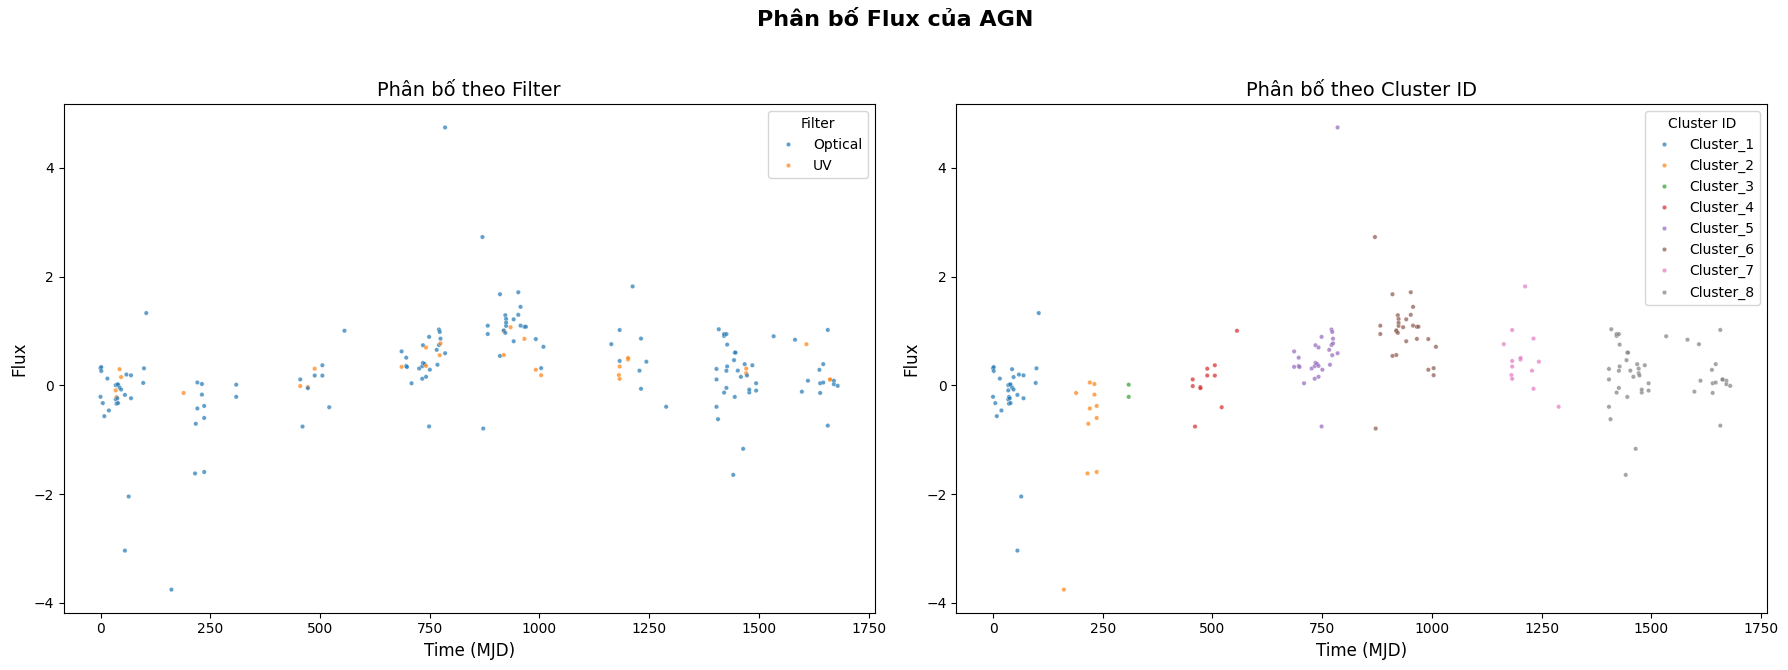

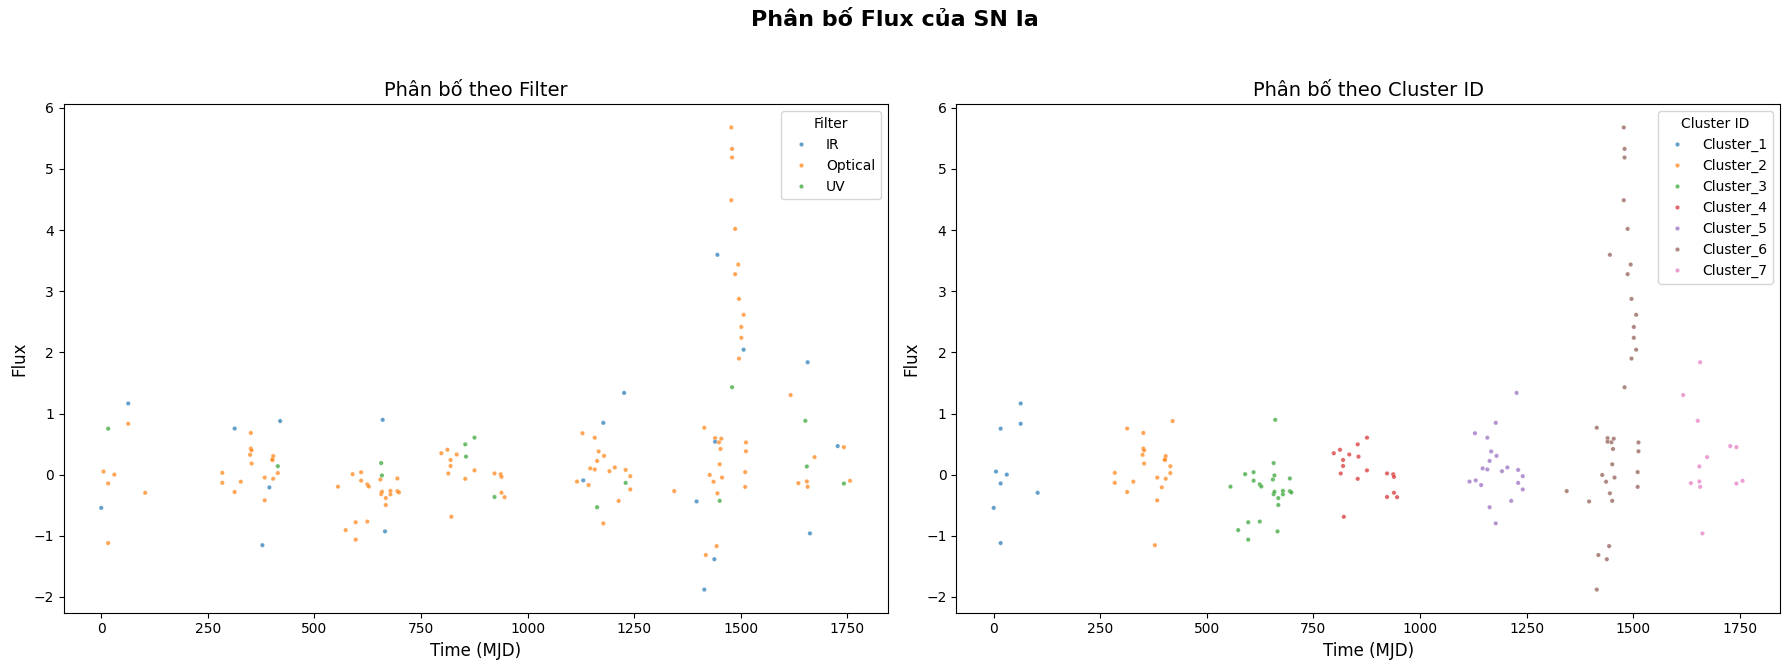

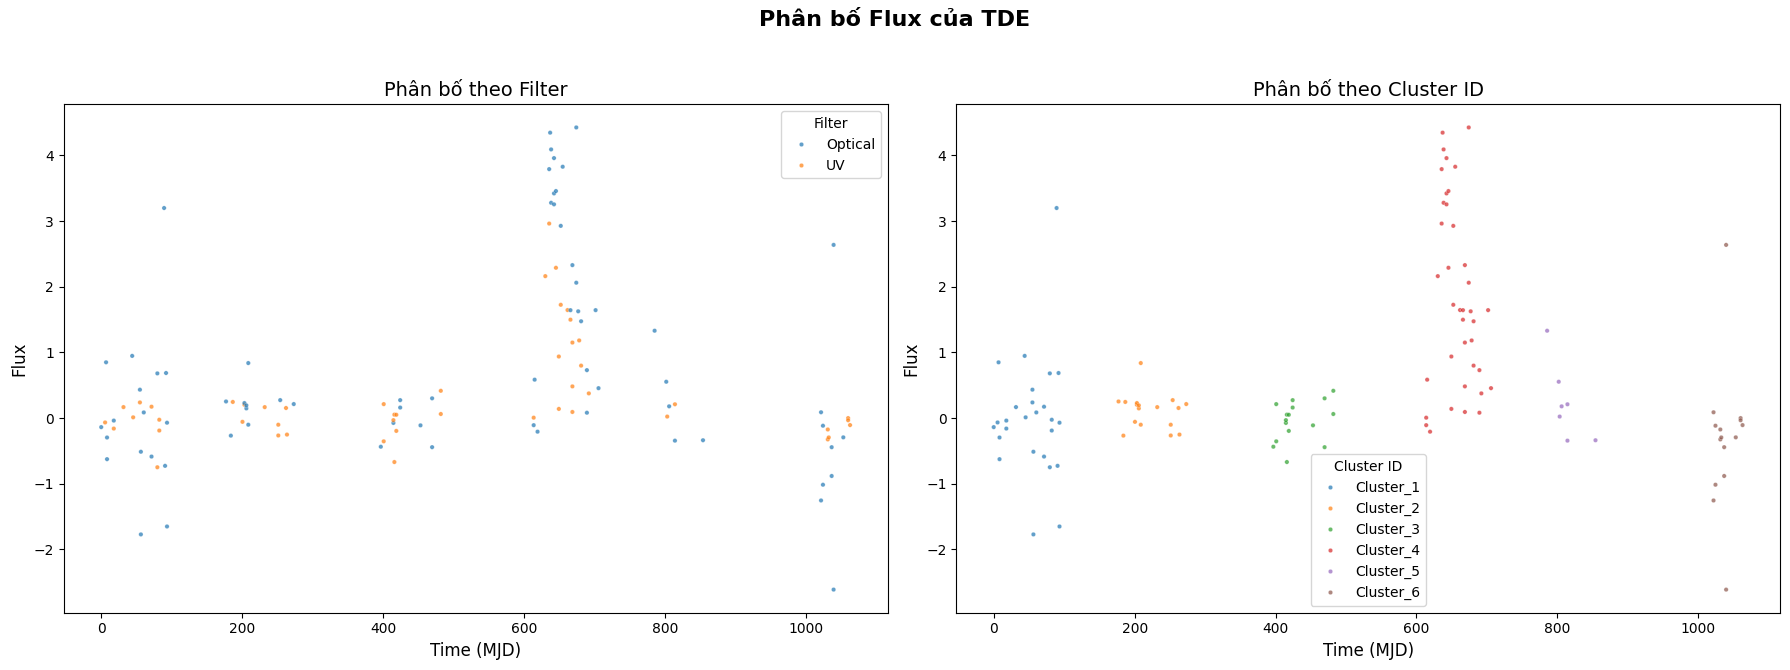

[5, 1, 2]

In [9]:

def random_sampling_split(df_object, required_points, max_sample):
    """
    Tạo các mẫu (splits) bằng cách lấy mẫu ngẫu nhiên (uniform) số lượng điểm 
    nhất định từ mỗi Filter (ống kính).
    
    Args:
        df_object (pd.DataFrame): DataFrame của 1 object_id, đã gộp log và split.
        points_on_each_filter (int): Số dòng/điểm cần lấy trên mỗi filter.
        max_sample (int): Số lượng splits tối đa muốn tạo ra.
        seed (int): Random seed cho việc lấy mẫu.
    
    Returns:
        list: Danh sách các DataFrame nhỏ (splits) đã được lấy mẫu ngẫu nhiên.
    """
    
    # 1. Grouping theo Filter
    grouped = df_object.groupby('Filter')
    
    # 2. Xác định margin (số lượng mẫu dư ra)
    min_group_length = grouped.size().min()
    
    # Số lượng bản ghi cần thiết cho 1 mẫu hoàn chỉnh (đủ tất cả filters)
    margin = min_group_length - required_points
    if not max_sample : max_sample = margin
    
    # 3. Xác định Số lần Lặp
    # margin + 1 là số lượng vị trí bắt đầu có thể có, tính cả vị trí cuối cùng.
    num_iterations = min(margin, max_sample) if margin > 0 else 1
    
    splits = []
    
    # 4. Lấy mẫu ngẫu nhiên các vị trí bắt đầu    
    for _ in range(num_iterations):
        all_filters_sample = []
        
        # Lấy mẫu từ mỗi group
        for filter_name, group in grouped:
            
            sample = group.sample(n=min( len(group), required_points ), 
                                random_state=None) 
            
            all_filters_sample.append(sample)
            
        # Hợp nhất các mẫu từ các filter
        split_df = pd.concat(all_filters_sample, ignore_index=True)
        splits.append(split_df)
        
    return splits

def time_based_clustering_split(df_object):
    """
    Phân tách DataFrame của một object_id thành các cluster dựa trên khoảng cách thời gian 
    lớn hơn ngưỡng: mean(time_diff) + std(time_diff).
    
    Args:
        df_object (pd.DataFrame): DataFrame của 1 object_id, đã gộp log và split.
    
    Returns:
        list: Danh sách các DataFrame cluster.
    """

    # 1. Sắp xếp theo thời gian Time (MJD)
    # Rất quan trọng: Chỉ sắp xếp df_temp, không thay đổi df_object gốc
    df_object = df_object.sort_values('Time (MJD)').reset_index(drop=True)
    
    # 2. Tính time_diff giữa các dòng liên tiếp
    time_diff = df_object['Time (MJD)'].diff()
    
    # 3. Tính Ngưỡng Phân tách (separation_line)
    # Bỏ qua NaN (dòng đầu tiên) khi tính mean và std
    mean_diff = time_diff.mean()
    std_diff = time_diff.std()
    
    # Ngưỡng phân tách
    separation_line = mean_diff + std_diff * 2
    
    # Nếu không có đủ dữ liệu (ví dụ: chỉ 1 dòng), không thể tính toán, trả về toàn bộ
    if np.isnan(separation_line):
        return [df_object]
        
    # 4. Xác định Điểm Chia tách và Tạo Nhãn Cluster
    # Dòng đầu tiên (time_diff=NaN) được xử lý là False (không phải điểm chia tách)
    # mask: True nếu là khoảng nghỉ lớn
    is_split_point = (time_diff >= separation_line)
    is_split_point.iloc[0] = False 
    
    # Tạo Cluster ID: Tăng ID mỗi khi gặp một khoảng nghỉ lớn
    df_object['cluster_id'] = is_split_point.cumsum()
    
    # 5. Tách DataFrame thành List Cluster
    cluster_list = [group.drop(columns='cluster_id') 
                    for name, group in df_object.groupby('cluster_id')]
    
    # Ghi chú về Xử lý Đường Phân tách:
    # Logic cumsum đảm bảo dòng có time_diff > separation_line 
    # (tức là dòng *sau* khoảng nghỉ) sẽ bắt đầu cluster mới (ID tăng). 
    # Dòng liền trước đó (dòng kết thúc cluster cũ) sẽ nằm trong cluster cũ, 
    
    return cluster_list

def identify_event_phases(cluster_list: list[pd.DataFrame]):
    """
    Phân loại các cụm quan sát thành 3 giai đoạn dựa trên đỉnh sáng (Peak Flux).
    
    Args:
        cluster_list: List các DataFrame, mỗi DF là 1 cụm quan sát (output của time_based_clustering_split).
        flux_col: Tên cột dùng để xác định độ sáng cực đại (nên dùng 'Corrected Flux' hoặc 'Flux').
        
    Returns:
        tuple: (pre_main_list, main_cluster_list, post_main_list)
               Mỗi phần tử là một List[DataFrame].
    """
    # 1. Xử lý trường hợp danh sách rỗng
    if not cluster_list:
        return [], [], []

    # 3. Tìm Main Cluster (Cụm chứa Global Max Flux)
    max_flux_val = -np.inf
    main_cluster_idx = -1

    for idx, df in enumerate(cluster_list):
        # Lấy max flux trong cluster hiện tại
        # Cần xử lý NaN nếu có (dù pre-processing nên sạch rồi)
        condition = ( df['Flux'] / df['Flux_err'] ).abs() >= 2
        current_max = df[condition]['Flux'].mean()
        
        if pd.isna(current_max):
            continue
            
        if current_max > max_flux_val:
            max_flux_val = current_max
            main_cluster_idx = idx

    # 4. Phân chia Pre - Main - Post
    if main_cluster_idx == -1:
        # Trường hợp hy hữu: toàn bộ dữ liệu là NaN hoặc rỗng
        return [], cluster_list, [] 
        # Hoặc return [], [], [] tùy strategy, ở đây tôi trả về tất cả vào Main để debug
    
    # List slicing
    pre_main_list = cluster_list[:main_cluster_idx]
    main_cluster_list = [cluster_list[main_cluster_idx]] # Đóng gói vào list để đồng bộ output
    post_main_list = cluster_list[main_cluster_idx+1:]

    return pre_main_list, main_cluster_list, post_main_list
    

##-- Ví dụ sử dụng --   
sample_cluster = []
for SpecType, data in sample_log_raw.groupby('SpecType') :
    plot_cluster_and_filter_distribution(time_based_clustering_split(data), SpecType, filter_list=sample_log_raw['Filter'].unique().tolist())
    if SpecType == 'AGN' :
        sample_cluster = time_based_clustering_split(data)

[len(x) for x in identify_event_phases(sample_cluster)]

# 3. <a id='toc3_'></a>[Xử lý data](#toc0_)

Cơ chế:
- Tạo features bằng các hàm đã chuẩn bị
- Tách Train-Validation tách khỏi Test-set



In [46]:
from scipy import stats, integrate
import warnings
from scipy.optimize import curve_fit, OptimizeWarning

# --------------------------------------------------------------------------------
# 1. HELPER FUNCTIONS: COSMOLOGY & STATS
# --------------------------------------------------------------------------------

def weighted_mean(values, errors):
    if len(values) == 0: return np.nan
    weights = 1.0 / (errors**2 + 1e-6)
    return np.sum(values * weights) / np.sum(weights)

def calc_spectral_centroid(df):
    """Tính trọng tâm phổ (Spectral Centroid). Chỉ dùng Flux > 0."""
    mask = (df['Flux'] > 0) & ((df['Flux'] / df['Flux_err']).abs() > 1)
    if not mask.any(): return 0
    # Centroid = Sum(F * lambda) / Sum(F)
    num = np.sum(df.loc[mask, 'Flux'] * df.loc[mask, 'lambda_rest'])
    den = np.sum(df.loc[mask, 'Flux'])
    return num / den if den != 0 else 0

# --------------------------------------------------------------------------------
# 2. HELPER PATTERN FITTING: BAZIN & POWER LAW
# --------------------------------------------------------------------------------

def bazin_func(t, A, t0, t_fall, t_rise, B):
    """
    Phiên bản Bazin chống tràn số (Overflow-safe).
    """
    # 1. Tránh chia cho 0 hoặc số quá nhỏ
    t_rise = max(t_rise, 1e-5)
    t_fall = max(t_fall, 1e-5)
    
    # 2. Tính toán tham số mũ
    arg_rise = -(t - t0) / t_rise
    arg_fall = -(t - t0) / t_fall
    
    # 3. Kẹp giá trị (Clipping)
    # np.exp(709) là giới hạn của float64. Ta kẹp ở +/- 700 để an toàn.
    # Nếu arg < -700 -> exp ~ 0
    # Nếu arg > 700 -> exp ~ rất lớn (nhưng không báo lỗi)
    arg_rise = np.clip(arg_rise, -700, 700)
    arg_fall = np.clip(arg_fall, -700, 700)
    
    # 4. Tính toán
    # Công thức: A * e^fall / (1 + e^rise) + B
    return A * np.exp(arg_fall) / (1 + np.exp(arg_rise)) + B

def fit_bazin_on_series(time, flux, flux_err):
    """
    Fit Bazin an toàn, bắt các Warning và trả về NaN nếu thất bại.
    """
    # 1. Làm sạch dữ liệu đầu vào (Data Cleaning)
    # Loại bỏ NaN, Inf và flux_err <= 0
    mask = np.isfinite(time) & np.isfinite(flux) & np.isfinite(flux_err) & (flux_err > 0)
    
    t_clean = time[mask]
    f_clean = flux[mask]
    e_clean = flux_err[mask]
    
    # Cần tối thiểu 5 điểm sạch để fit 5 tham số
    if len(t_clean) < 5:
        return [np.nan] * 5
    
    # 2. Dự đoán tham số khởi tạo (Heuristic Initialization)
    try:
        peak_idx = np.argmax(f_clean)
        A_init = f_clean[peak_idx]      # Biên độ
        t0_init = t_clean[peak_idx]     # Thời gian đỉnh
        B_init = np.min(f_clean)        # Nền
        
        # [A, t0, t_fall, t_rise, B]
        p0 = [A_init, t0_init, 50.0, 10.0, B_init] 
        
        # Bounds: A, t_fall, t_rise > 0
        bounds_lower = [0, -np.inf, 1e-3, 1e-3, -np.inf]
        bounds_upper = [np.inf, np.inf, 5000, 5000, np.inf] # Giới hạn time constant tránh vô cực
    except:
        return [np.nan] * 5

    # 3. Fit với Error Handling
    with warnings.catch_warnings():
        # Bỏ qua các cảnh báo Overflow/Optimize trong quá trình fit để không rác màn hình
        warnings.simplefilter("ignore", RuntimeWarning)
        warnings.simplefilter("ignore", OptimizeWarning)
        
        try:
            # Thêm sigma=flux_err và absolute_sigma=True để tính sai số chuẩn
            popt, pcov = curve_fit(
                bazin_func, 
                t_clean, 
                f_clean, 
                p0=p0, 
                sigma=e_clean, 
                bounds=(bounds_lower, bounds_upper), 
                maxfev=5000,          # Tăng số lần thử tối đa
                absolute_sigma=True   # Quan trọng khi dùng sigma
            )

            # Tính độ lệch chuẩn từ ma trận hiệp phương sai
            perr = np.sqrt(np.diag(pcov)) 
            return popt, perr
        except:
            # Trả về NaN nếu lỗi
            return np.full(5, np.nan), np.full(5, np.nan)

def fit_power_law_tail(time, flux, t_peak):
    # Data Cleaning
    mask = np.isfinite(time) & np.isfinite(flux) & (time > t_peak) & (flux > 0)
    t_tail = time[mask]
    f_tail = flux[mask]
    
    if len(t_tail) < 3:
        return np.nan
        
    x_log = np.log10(t_tail - t_peak + 1e-5) 
    y_log = np.log10(f_tail)
    
    # Check lại lần nữa cho chắc (tránh log ra nan/inf)
    mask_log = np.isfinite(x_log) & np.isfinite(y_log)
    if np.sum(mask_log) < 3:
        return np.nan
        
    try:
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_log[mask_log], y_log[mask_log])
        return -slope
    except:
        return np.nan


# --------------------------------------------------------------------------------
# 3. STAGE PROCESSORS (ĐÃ SỬA: PHYSICS FEATURES)
# --------------------------------------------------------------------------------

def process_pre_event(pre_list, main_peak_flux):
    """
    Kết hợp: Legacy Stats (Detection, Median, Ratio) + New Physics (Centroid).
    Tính cho từng Cluster -> Trung bình.
    """
    stats = {
        'pre_median_flux': [], 
        'pre_flux_95th_ratio': [], 
        'pre_detection_ratio': [],
        'pre_centroid': [] # New Physics,
    }

    default_keys = [
        'pre_median_flux', 'pre_flux_95th_ratio', 
        'pre_detection_ratio', 'pre_centroid', 
        'last_pre_centroid', 'last_pre_time' # <--- Thêm time để tính Speed
    ]
    
    if not pre_list:
        return {k: (np.nan if 'centroid' in k or 'time' in k else 0.0) for k in default_keys}

    for df in pre_list:
        if df.empty: continue
        
        # --- Legacy Features ---
        snr = df['Flux'] / df['Flux_err']
        stats['pre_detection_ratio'].append((snr > 5).mean())
        stats['pre_median_flux'].append(df['Flux'].median())
        
        flux_95 = df['Flux'].quantile(0.95)
        if main_peak_flux > 0:
            stats['pre_flux_95th_ratio'].append(flux_95 / main_peak_flux)
        else:
            stats['pre_flux_95th_ratio'].append(np.nan)
            
        # --- New Physics ---
        stats['pre_centroid'].append(calc_spectral_centroid(df))

    # Aggregation
    final_feats = {}
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        
        final_feats['pre_median_flux'] = np.nanmean(stats['pre_median_flux'])
        final_feats['pre_flux_95th_ratio'] = np.nanmean(stats['pre_flux_95th_ratio'])
        final_feats['pre_detection_ratio'] = np.nanmean(stats['pre_detection_ratio'])
        final_feats['pre_centroid'] = np.nanmean(stats['pre_centroid']) # Dùng để tính Shift
        
        # --- Lấy cụm Pre cuối cùng (Sát Main Event nhất) ---
        if stats['pre_centroid']:
            # Lấy giá trị centroid của cụm cuối cùng trong list
            final_feats['last_pre_centroid'] = stats['pre_centroid'][-1]
            
            # [QUAN TRỌNG] Phải lấy Time của cụm cuối cùng để tính Speed
            # Giả định pre_list được sắp xếp theo thời gian
            last_df = pre_list[-1]
            final_feats['last_pre_time'] = last_df['Time (MJD)'].mean()
        else:
            final_feats['last_pre_centroid'] = np.nan
            final_feats['last_pre_time'] = np.nan


    return final_feats

def process_main_event(main_df):
    """
    Kết hợp: Legacy Stats (Kurtosis, Skew, Fitting) + New Physics (UV Ratio, Centroid).
    """
    features = {}
    main_peak_flux = np.nan
    main_peak_time = np.nan
    
    if main_df.empty:
        return {}, main_peak_flux

    # --- A. PHYSICS & ADVANCED SHAPE STATS ---
    
    # --- 1. Tìm đỉnh sáng nhất (Global Peak) ---
    try:
        peak_idx = main_df['Flux'].idxmax()
        peak_row = main_df.loc[peak_idx]
        
        features['peak_M_abs'] = peak_row['M_abs']
        features['log_peak_luminosity'] = peak_row['Log_Luminosity']
        
        main_peak_flux = peak_row['Flux']
        main_peak_time = peak_row['Time (MJD)']
    except:
        features['peak_M_abs'] = np.nan
        features['log_peak_luminosity'] = np.nan
        # Nếu không tìm được peak, trả về ngay
        return features, np.nan
    

    # --- 2. Shape Statistics (Mở rộng từ Kurtosis) ---
    # Kurtosis đang top 1 feature, nên ta bổ sung thêm Skewness
    flux_vals = main_df['Flux'].values
    err_vals = main_df['Flux_err'].values
    
    if len(main_df) > 3:
        features['main_kurtosis'] = main_df['Flux'].kurtosis()
        features['main_skew'] = main_df['Flux'].skew()
        
        # Amplitude Ratio: (Max - Median) / Std
        # Đo xem đỉnh có "nổi" lên hẳn so với nền của chính cụm đó không
        std_val = np.std(flux_vals)
        if std_val > 0:
            features['main_amplitude_ratio'] = (np.max(flux_vals) - np.median(flux_vals)) / std_val
        else:
            features['main_amplitude_ratio'] = np.nan
    else:
        features['main_kurtosis'] = np.nan
        features['main_skew'] = np.nan
        features['main_amplitude_ratio'] = np.nan


    # --- 3. PHYSICS-BASED SHAPE FITTING (PER WAVELENGTH BIN) ---
    # Thay vì chỉ fit trên 1 filter nhiều điểm nhất, ta fit trên từng vùng năng lượng.
    # Các vùng: UV, Optical, IR (đã được gán nhãn ở bước Preprocess)
    
    BIN_LABELS = ['Optical', 'UV', 'IR']        # 'All' did not work
    opt_params = [np.nan] * 5                  # Tham số Bazin tham chiếu từ Optical    


    for bin_label in BIN_LABELS:
        # Lọc dữ liệu thuộc bin này
        if bin_label == 'All':
            df_fit = main_df.sort_values('Time (MJD)') 
        else:
            mask_bin = main_df['Filter'] == bin_label
            df_fit = main_df[mask_bin].sort_values('Time (MJD)')
        
        # Chuẩn bị dữ liệu fit
        t_fit = df_fit['Time (MJD)'].values
        f_fit = df_fit['Flux'].values
        fe_fit = df_fit['Flux_err'].values
        
        # Khởi tạo mặc định là NaN
        features[f'{bin_label}_bazin_tau_fall'] = np.nan
        features[f'{bin_label}_bazin_tau_rise'] = np.nan
        features[f'{bin_label}_power_law_alpha'] = np.nan
        features[f'{bin_label}_bazin_rmse'] = np.nan     # <--- Goodness of Fit 
        
        # Chỉ fit nếu đủ dữ liệu (Bazin cần tối thiểu 5 điểm)
        if len(df_fit) >= 5:
            # 1. Fit Bazin
            # params: [A, t0, t_fall, t_rise, B]
            bazin_params, bazin_err = fit_bazin_on_series(t_fit, f_fit, fe_fit)

            # [QUAN TRỌNG] Lưu lại tham số Optical để dùng cho UV/IR
            if bin_label == 'Optical' and not np.isnan(bazin_params[0]): 
                opt_params = bazin_params
            
            features[f'{bin_label}_bazin_tau_fall'] = bazin_params[2]
            features[f'{bin_label}_bazin_tau_rise'] = bazin_params[3]

            features[f'{bin_label}_bazin_tau_fall_err'] = bazin_err[2]
            features[f'{bin_label}_bazin_tau_rise_err'] = bazin_err[3]

            # --- 1. Tính Goodness of Fit (RMSE) ---
            # Tính Flux dự đoán từ tham số vừa fit được
            flux_predicted = bazin_func(t_fit, *bazin_params)
            
            # Tính phần dư (Residuals): Thực tế - Dự đoán
            residuals = f_fit - flux_predicted
            
            # Tính RMSE (Căn bậc hai của trung bình bình phương sai số)
            rmse = np.sqrt(np.mean(residuals**2))
            
            # (Optional) Normalized RMSE: Chia cho biên độ Flux để công bằng giữa vật thể sáng/tối
            # flux_range = np.max(f_fit) - np.min(f_fit)
            # if flux_range > 0: rmse = rmse / flux_range
            features[f'{bin_label}_bazin_rmse'] = rmse

            
            # ---  2. Fit Power-law Alpha ---
            # Xác định t_peak cục bộ cho bin này
            # Ưu tiên dùng t0 từ Bazin, nếu fail thì dùng thời điểm max flux thô
            if not np.isnan(bazin_params[1]):
                t_peak_local = bazin_params[1]
            else:
                # Fallback: Lấy thời gian của điểm sáng nhất trong bin này
                try:
                    t_peak_local = df_fit.loc[df_fit['Flux'].idxmax(), 'Time (MJD)']
                except:
                    t_peak_local = np.nan
            
            if not np.isnan(t_peak_local):
                features[f'{bin_label}_power_law_alpha'] = fit_power_law_tail(t_fit, f_fit, t_peak_local)

        if bin_label == 'Optical':
            continue  # Bỏ qua bước 3 cho Optical
        

        # --- 3. Fit Bazin với Tham số Bắt buộc từ Optical (Chỉ cho UV và IR) ---
        features[f'{bin_label}_forced_amplitude'] = np.nan
        features[f'{bin_label}_optical_ratio'] = np.nan
        if not np.isnan(opt_params[0]) and len(t_fit) >= 2:
            # Lấy tham số cố định từ Optical
            # opt_params thứ tự: [A, t0, t_fall, t_rise, B]
            fixed_t0 = opt_params[1]
            fixed_t_fall = opt_params[2]
            fixed_t_rise = opt_params[3]

            p0_forced = [np.max(f_fit) - np.min(f_fit), np.min(f_fit)]
            
            # Tạo một hàm 'bazin_forced' tạm thời chỉ nhận 2 biến (A, B) để tối ưu,
            # còn các biến khác (t0, t_fall, t_rise) được truyền cố định vào 'bazin_func' gốc.
            bazin_forced = lambda t, A, B: bazin_func(t, A, fixed_t0, fixed_t_fall, fixed_t_rise, B)
                
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", OptimizeWarning)
                    
                    popt_forced, _ = curve_fit(
                        bazin_forced, t_fit, f_fit, 
                        p0=p0_forced, 
                        sigma=fe_fit, 
                        maxfev=5000,
                        absolute_sigma=True 
                    )
                
                # Nếu chạy êm xuôi tới đây thì lưu kết quả
                features[f'{bin_label}_forced_amplitude'] = popt_forced[0]
                
                # Tính Ratio an toàn
                if abs(opt_params[0]) > 1e-5:
                    features[f'{bin_label}_optical_ratio'] = popt_forced[0] / opt_params[0]
                else:
                    features[f'{bin_label}_optical_ratio'] = 0
                    
            except Exception:
                # Nếu fit không hội tụ hoặc Covariance fail -> Giữ nguyên NaN
                pass


    # --- 4. NEW PHYSICS FEATURES (Rest-frame) ---
    # 4.1 Centroid và Global Shift Speed
    features['main_centroid'] = calc_spectral_centroid(main_df)
    features['main_time_mean'] = main_df['Time (MJD)'].mean()

    # 4.2 Color Gradient (Độ dốc thay đổi màu: Rise vs Fall)
    # Tách data thành 2 nửa: Trước đỉnh (Rise) và Sau đỉnh (Fall)
    mask_rise = main_df['Time (MJD)'] <= main_peak_time
    mask_fall = main_df['Time (MJD)'] > main_peak_time
    
    df_rise = main_df[mask_rise]
    df_fall = main_df[mask_fall]
    
    # Chỉ tính nếu cả 2 nửa đều có dữ liệu
    if not df_rise.empty and not df_fall.empty:
        features['main_rise_centroid'] = calc_spectral_centroid(df_rise)
        features['main_fall_centroid'] = calc_spectral_centroid(df_fall)
        
        t_rise = df_rise['Time (MJD)'].mean()
        t_fall = df_fall['Time (MJD)'].mean()
        
        # Tính Gradient = (Delta Centroid) / (Delta Time)
        dt = t_fall - t_rise
        if dt > 0:
            features['main_color_gradient'] = (features['main_fall_centroid'] - features['main_rise_centroid']) / dt
        else:
            features['main_color_gradient'] = 0 # Hoặc np.nan
    else:
        features['main_color_gradient'] = np.nan

    

    
    # Weighted Mean Flux per Bin & Ratios
    # Bins: UV, Optical, IR
    total_w_mean = 0
    for label in ['UV', 'Optical', 'IR']:
        sub = main_df[main_df['Filter'] == label]
        if not sub.empty:
            w_mean = weighted_mean(sub['Flux'].values, sub['Flux_err'].values)
            features[f'main_mean_flux_{label}'] = w_mean
            if w_mean > 0: total_w_mean += w_mean
        else:
            features[f'main_mean_flux_{label}'] = 0.0
            
    # Calculate Ratios
    if total_w_mean > 0:
        features['main_UV_ratio'] = features['main_mean_flux_UV'] / total_w_mean
        features['main_IR_ratio'] = features['main_mean_flux_IR'] / total_w_mean
    else:
        features['main_UV_ratio'] = 0.0
        features['main_IR_ratio'] = 0.0


    return features, main_peak_flux

def process_post_event(post_list):
    """
    Kết hợp: Legacy Stats (SNR, Detection) + New Physics (Centroid).
    """
    stats = {
        'median_snr': [],
        'detection_ratio': [],
        'centroid': []
    }

    default_keys = [
        'post_median_snr', 'post_detection_ratio', 
        'post_centroid',
        'first_post_centroid', 'first_post_time' # <--- Thêm time để tính Speed
    ]
    
    if not post_list:
        return {k: (np.nan if 'centroid' in k or 'time' in k else 0.0) for k in default_keys}
    
    for df in post_list:
        if df.empty: continue
        
        # --- Legacy ---
        snr = df['Flux'] / df['Flux_err']
        stats['detection_ratio'].append((snr > 3).mean())
        
        mask_pos = snr > 0
        if mask_pos.any():
            stats['median_snr'].append(snr[mask_pos].median())
        else:
            stats['median_snr'].append(0.0)
            
        # --- New Physics ---
        stats['centroid'].append(calc_spectral_centroid(df))
        
    final_feats = {}
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        final_feats['post_detection_ratio'] = np.nanmean(stats['detection_ratio'])
        final_feats['post_median_snr'] = np.nanmean(stats['median_snr'])
        final_feats['post_centroid'] = np.nanmean(stats['centroid']) # Dùng để tính Shift

        # --- Lấy cụm Post đầu tiên (Sát Main Event nhất) ---
        if stats['centroid']:
            # Lấy giá trị centroid của cụm đầu tiên trong list
            final_feats['first_post_centroid'] = stats['centroid'][0]
            
            # [QUAN TRỌNG] Phải lấy Time của cụm đầu tiên để tính Speed
            # Giả định post_list được sắp xếp theo thời gian
            first_df = post_list[0]
            final_feats['first_post_time'] = first_df['Time (MJD)'].mean()
        else:
            final_feats['first_post_centroid'] = np.nan
            final_feats['first_post_time'] = np.nan

    return final_feats

# --------------------------------------------------------------------------------
# 4. MAIN PIPELINE (ĐÃ SỬA: INTEGRATION)
# --------------------------------------------------------------------------------

def feature_extraction_pipeline(df):
    # 1. Metadata
    meta_cols = ['object_id', 'Z', 'SpecType']
    available_meta = [c for c in meta_cols if c in df.columns]
    metadata = df.iloc[0][available_meta].to_dict()
    
    # 2. Clusters & Phases (Sử dụng hàm của user)
    clusters = time_based_clustering_split(df)
    pre_list, main_list, post_list = identify_event_phases(clusters)
    
    # 3. Main Event
    main_df = main_list[0] if main_list else pd.DataFrame(columns=df.columns)
    main_feats, main_peak_flux = process_main_event(main_df)
    
    # 4. Pre & Post (Aggregated)
    pre_feats = process_pre_event(pre_list, main_peak_flux)
    post_feats = process_post_event(post_list)
    
    # 5. Calculate Centroid Shifts (Contrast)
    shifts = {}
    
    # Shift Pre -> Main
    if 'main_centroid' in main_feats and 'pre_centroid' in pre_feats:
        shifts['centroid_shift_pre_main'] = main_feats['main_centroid'] - pre_feats['pre_centroid']
        shifts['centroid_shift_speed_pre_main'] = (main_feats['main_centroid'] - pre_feats['last_pre_centroid']) / (main_df['Time (MJD)'].mean() - pre_feats['last_pre_time'] + 1e-5)
    else:
        shifts['centroid_shift_pre_main'] = np.nan
        shifts['centroid_shift_speed_pre_main'] = np.nan

    # Shift Main -> Post
    if 'main_centroid' in main_feats and 'post_centroid' in post_feats:
        shifts['centroid_shift_main_post'] = post_feats['post_centroid'] - main_feats['main_centroid']
        shifts['centroid_shift_speed_main_post'] = (post_feats['first_post_centroid'] - main_feats['main_centroid']) / (post_feats['first_post_time'] - main_df['Time (MJD)'].mean() + 1e-5)    
    else:
        shifts['centroid_shift_main_post'] = np.nan
        shifts['centroid_shift_speed_main_post'] = np.nan

    pre_feats.pop('last_pre_centroid')
    post_feats.pop('first_post_centroid')
        
    # Xóa các cột centroid trung gian nếu không muốn giữ lại (chỉ giữ shift), 
    # nhưng user không yêu cầu xóa nên cứ để đó hoặc lọc sau.
    # Ở đây tôi giữ lại tất cả để bạn dễ kiểm tra.
    
    # 6. Final Series
    full_features = {**metadata, **main_feats, **pre_feats, **post_feats, **shifts}
    
    return pd.Series(full_features)

feature_extraction_pipeline(sample_log_single_object)

object_id                         amon_imloth_luin
Z                                           0.7766
SpecType                                       TDE
peak_M_abs                              -21.204582
log_peak_luminosity                       8.481833
main_kurtosis                            -1.153338
main_skew                                 0.302004
main_amplitude_ratio                      1.982842
Optical_bazin_tau_fall                   43.062628
Optical_bazin_tau_rise                    0.052145
Optical_power_law_alpha                   0.322119
Optical_bazin_rmse                        0.745325
Optical_bazin_tau_fall_err                5.257838
Optical_bazin_tau_rise_err        180319400.649172
UV_bazin_tau_fall                        27.993689
UV_bazin_tau_rise                         0.116662
UV_power_law_alpha                         0.23398
UV_bazin_rmse                             0.572882
UV_bazin_tau_fall_err                      4.15081
UV_bazin_tau_rise_err          

## 3.2. Full pipelines

In [47]:
from tqdm import tqdm

def full_process(df_log, df_split, split_name:str=None):
    
    # 0. Nhóm các SpecType thiểu số lại
    df_log['SpecType'] = df_log['SpecType'].mask(~df_log['SpecType'].isin(['AGN', 'TDE']), 'SN')
    
    # --- BƯỚC 1: Hợp nhất df ---
    total_df = join_DataFrame(df_log, df_split)


    # --- BƯỚC 2:. Extinct flux (Giả định jurassic_park trả về một Series với cột tên là 'Flux') ---
    preprocessed_df = preprocess_lightcurves(total_df)

    # --- BƯỚC 2':. Drop các cột không cần thiết
    total_df = preprocessed_df.drop(['Z_err', 'split', 'EBV'], axis = 1)
    
    
    features_extracted_df = []
    # Nhóm lại theo object_id để xử lý từng đối tượng
    for obj_id, group in tqdm(total_df.groupby('object_id'), desc=f'Extracting {split_name if split_name else "unknown"}: '):
        group['object_id'] = obj_id 
    
        # Gọi hàm trích xuất
        feats = feature_extraction_pipeline(group)

        features_extracted_df.append(feats)
    
    result = pd.DataFrame(features_extracted_df)
    return result


sampled_training = process_and_combine_splits(
    sample_log,
    'train_full_lightcurves.csv',
    full_process
)

sampled_training

Extracting split_01: 100%|██████████| 3/3 [00:00<00:00, 24.10it/s]


,object_id,Z,SpecType,peak_M_abs,log_peak_luminosity,main_kurtosis,main_skew,main_amplitude_ratio,Optical_bazin_tau_fall,Optical_bazin_tau_rise,Optical_power_law_alpha,Optical_bazin_rmse,Optical_bazin_tau_fall_err,Optical_bazin_tau_rise_err,UV_bazin_tau_fall,UV_bazin_tau_rise,UV_power_law_alpha,UV_bazin_rmse,UV_bazin_tau_fall_err,UV_bazin_tau_rise_err,UV_forced_amplitude,UV_optical_ratio,IR_bazin_tau_fall,IR_bazin_tau_rise,IR_power_law_alpha,IR_bazin_rmse,IR_forced_amplitude,IR_optical_ratio,main_centroid,main_time_mean,main_rise_centroid,main_fall_centroid,main_color_gradient,main_mean_flux_UV,main_mean_flux_Optical,main_mean_flux_IR,main_UV_ratio,main_IR_ratio,pre_median_flux,pre_flux_95th_ratio,pre_detection_ratio,pre_centroid,last_pre_time,post_detection_ratio,post_median_snr,post_centroid,first_post_time,centroid_shift_pre_main,centroid_shift_speed_pre_main,centroid_shift_main_post,centroid_shift_speed_main_post,IR_bazin_tau_fall_err,IR_bazin_tau_rise_err
0,amon_imloth_luin,0.7766,TDE,-21.204582,8.481833,-1.153338,0.302004,1.982842,43.062628,0.052145,0.322119,0.745325,5.257838,1.803194e+08,27.993689,0.116662,0.23398,0.572882,4.150810,2.462292e+08,1.417237,0.326462,NaN,NaN,NaN,NaN,NaN,NaN,4459.207209,657.091261,4510.209756,4057.716934,-11.013187,1.207375,1.970725,0.000000,0.379905,0.00000,0.041731,0.123522,0.000000,4363.039868,431.452177,0.000000,0.578902,2447.089947,811.383622,96.167341,4.408476,-2012.117262,2.819146,NaN,NaN
1,cirion_ira_Ithil,0.3325,SN,-19.274104,7.709642,-0.470388,0.667715,2.590773,13.119389,4.830088,0.559325,0.674640,1.450972,4.029888e-01,NaN,NaN,NaN,NaN,NaN,NaN,3.818485,0.366944,162.93515,0.095946,NaN,0.42962,25.882143,2.487191,5658.769438,1463.071609,5598.716909,5684.651676,1.414326,0.114321,1.818486,0.346097,0.050165,0.15187,-0.000981,0.116707,0.000000,4030.114927,1180.361394,0.000000,1.030320,6521.377995,1679.370680,1628.654511,-2.879312,862.608557,3.988036,233.730995,438207.519452
2,cuin_haudh_cenedril,0.5366,AGN,-19.704779,7.881912,3.985176,-0.126701,2.838104,9.371297,8.800667,0.713371,0.574356,14.001632,1.210248e+01,11.867961,10.631472,NaN,0.165602,46.153863,3.562886e+01,1.260502,1.679428,NaN,NaN,NaN,NaN,NaN,NaN,4623.481997,939.127162,5658.596902,4508.740111,-16.091650,0.958720,1.101760,0.000000,0.465290,0.00000,-0.002578,0.151360,0.007143,2463.268469,742.293926,0.196049,1.357203,4870.529291,1208.189268,2160.213527,-1.130677,247.047294,1.644284,NaN,NaN


## 3.3. <a id='toc3_2_'></a>[Chia train-test](#toc0_)

In [48]:
from sklearn.model_selection import train_test_split

# 1. Chuẩn bị Dữ liệu
train_log


# 2. Features Extraction & Augementation cho train_cv_log
train_log_extracted = process_and_combine_splits(
    train_log,
    'train_full_lightcurves.csv',
    full_process
).set_index('object_id')

train_label = train_log_extracted['SpecType']

Extracting split_20: 100%|██████████| 153/153 [00:16<00:00,  9.25it/s]


In [49]:
# 3. Phân chia Stratify (giữ nguyên tỉ lệ các nhãn)

train_cv_extracted, train_test_extracted, y_cv, y_test = train_test_split(
    train_log_extracted.drop(columns=['SpecType']), 
    train_label, 
    test_size=0.2, 
    stratify=train_label,  # <-- SỬ DỤNG STRATIFY
    random_state=None
)


X_cv = train_cv_extracted # Đặc trưng
y_cv = y_cv               # Nhãn mục tiêu


X_test = train_test_extracted
y_test = y_test


print('\n---Thông số training set: ---\n')
print(f'Training set: {len(y_cv)}     -- \
    AGN : {len(y_cv[y_cv == 'AGN'])}    -- \
    SN : {len(y_cv[y_cv == 'SN'])}      -- \
    TDE : {len(y_cv[y_cv == 'TDE'])}')

print(f'Testing set: {len(y_test)}     -- \
    AGN : {len(y_test[y_test == 'AGN'])}    -- \
    SN : {len(y_test[y_test == 'SN'])}      -- \
    TDE : {len(y_test[y_test == 'TDE'])}')

train_cv_extracted


---Thông số training set: ---

Training set: 2434     --     AGN : 1429    --     SN : 887      --     TDE : 118
Testing set: 609     --     AGN : 357    --     SN : 222      --     TDE : 30


,Z,peak_M_abs,log_peak_luminosity,main_kurtosis,main_skew,main_amplitude_ratio,Optical_bazin_tau_fall,Optical_bazin_tau_rise,Optical_power_law_alpha,Optical_bazin_rmse,UV_bazin_tau_fall,UV_bazin_tau_rise,UV_power_law_alpha,UV_bazin_rmse,UV_bazin_tau_fall_err,UV_bazin_tau_rise_err,UV_forced_amplitude,UV_optical_ratio,IR_bazin_tau_fall,IR_bazin_tau_rise,IR_power_law_alpha,IR_bazin_rmse,IR_forced_amplitude,IR_optical_ratio,main_centroid,main_time_mean,main_rise_centroid,main_fall_centroid,main_color_gradient,main_mean_flux_UV,main_mean_flux_Optical,main_mean_flux_IR,main_UV_ratio,main_IR_ratio,pre_median_flux,pre_flux_95th_ratio,pre_detection_ratio,pre_centroid,last_pre_time,post_detection_ratio,post_median_snr,post_centroid,first_post_time,centroid_shift_pre_main,centroid_shift_speed_pre_main,centroid_shift_main_post,centroid_shift_speed_main_post,Optical_bazin_tau_fall_err,Optical_bazin_tau_rise_err,IR_bazin_tau_fall_err,IR_bazin_tau_rise_err
object_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
lain_espalass_gellui,0.4431,-19.989415,7.995766,-0.062493,0.833010,2.983750,10.146527,10.889056,0.560778,0.732837,39.214768,4295.568229,-0.244910,0.229177,2.997414e+05,6.349692e+09,0.447065,0.094984,NaN,NaN,NaN,NaN,NaN,NaN,5692.333246,459.070054,5989.883246,5628.799080,-6.037476,0.053888,1.515242,0.000000,0.034342,0.000000,-0.036535,0.059646,0.000000,3661.340375,190.554481,0.000000,0.829926,4752.094547,705.043606,2030.992871,5.315183,-940.238699,-0.219626,3.322804e+00,2.129581e+00,NaN,NaN
ris_ai_hend,0.2209,-17.089343,6.835737,-1.185688,-0.391486,1.253750,12.538762,12.517748,0.481008,0.182543,NaN,NaN,NaN,NaN,NaN,NaN,0.187731,0.135466,66.445332,19.496145,0.780555,0.541057,1.325454,0.956440,6083.972483,286.364276,6570.303584,5807.602213,-9.652402,1.143168,0.995514,1.190369,0.343392,0.357570,-0.532114,-0.275632,0.000000,0.000000,0.000000,0.000000,0.056498,0.000000,579.199924,6083.972483,21.245570,-6083.972483,-20.776064,6.890895e+00,6.156775e+00,2.377644e+02,8.670569e+01
lagor_narthan_mindon,0.5087,-20.118671,8.047469,0.605157,0.795989,2.639933,17.659649,3.832487,0.640075,0.539383,6.320820,1725.842900,0.275284,1.101908,1.745297e+03,2.785077e+08,2.929919,0.411277,NaN,NaN,NaN,NaN,NaN,NaN,4554.279023,477.928077,4195.799081,4847.810910,13.908758,1.437755,1.965501,0.000000,0.422465,0.000000,0.020148,0.158079,0.000000,4853.119718,260.111288,0.005000,1.006086,5060.396709,716.668579,-298.840695,-1.926112,506.117686,-8.967657,1.977360e+00,2.887482e-01,NaN,NaN
callon_ennorath_andrann,0.3822,-18.670247,7.468099,3.623779,1.592377,2.931511,33.018620,1114.663073,1.932607,0.634330,0.692901,939.632816,0.216611,0.232842,3.430717e+00,9.277709e-07,4.261908,15.555883,NaN,NaN,NaN,NaN,7.109367,25.949052,5396.565782,1321.181526,7275.358125,4355.201059,-50.407710,0.088305,0.090800,1.019237,0.073689,0.850539,0.168538,0.600658,0.056410,5630.784081,1096.548300,0.000000,0.000000,NaN,NaN,-234.218298,-0.144504,NaN,NaN,2.445786e+06,2.568696e+08,NaN,NaN
rhosc_noroth_bragol,0.8452,-20.952348,8.380939,1.133815,0.945258,2.883179,35.635296,10.596331,NaN,0.545425,1.011658,1.011654,NaN,0.456713,1.773043e+01,1.777133e+01,-216.600354,-0.230851,NaN,NaN,NaN,NaN,NaN,NaN,3757.617265,1021.455990,4127.341724,3617.749863,-12.429649,1.565512,0.978346,0.000000,0.615409,0.000000,-0.002354,0.198278,0.000000,2085.684291,801.738402,0.354386,2.349640,3666.090273,1205.523609,1671.932975,5.499332,-91.526992,2.262923,8.347353e+07,7.380646e+06,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
drego_laes_amlug,0.5288,-21.033890,8.413556,2.161876,-1.261771,1.309306,18.477599,12.100736,0.047457,1.413567,NaN,NaN,NaN,NaN,NaN,NaN,3.955941,0.890583,NaN,NaN,NaN,NaN,NaN,NaN,4794.578841,1483.791856,4816.768456,4736.609388,-1.205520,6.271958,7.809419,0.000000,0.445408,0.000000,1.795555,0.305852,0.494949,4207.292250,1203.941261,1.000000,7

## 3.4. <a id='toc3_3_'></a>[Điều chỉnh nhãn](#toc0_)

In [50]:
from sklearn.utils.class_weight import compute_class_weight

CLASS_NAMES = train_label.unique()

# Gắn trọng số để coi trọng hơn nhãn TDE (theo proportion)
class_weights_dict = compute_class_weight(
    class_weight='balanced', 
    classes=CLASS_NAMES, 
    y=train_label
)

# Chuyển thành Dictionary để dễ tra cứu và boost
weights_map_init = dict(zip(CLASS_NAMES, class_weights_dict))
weights_map_boosted = weights_map_init.copy()
weights_map_boosted['TDE'] *= 5
class_weights_dict_boosted = weights_map_boosted.values()

weights_map_boosted

{'AGN': np.float64(0.5679357969391564),
 'SN': np.float64(0.9146378118425007),
 'TDE': np.float64(34.26801801801802)}

# 4. <a id='toc4_'></a>[Huấn luyện mô hình](#toc0_)

## 4.1. <a id='toc4_1_'></a>[Setup hyper-parameters](#toc0_)

In [51]:
from sklearn.model_selection import StratifiedKFold

N_SPLITS = 4

skf = StratifiedKFold(
    n_splits = N_SPLITS, 
    shuffle = True, 
    random_state = None
)

lgb_params = {
    # --- Cấu hình cơ bản ---
    'objective': 'multiclass',
    'boosting_type': 'gbdt',
    'num_class': len(CLASS_NAMES),
    'n_estimators': 2000,
    'learning_rate': 0.005,
    'num_leaves': 31,
    'max_depth': -1,
    'seed': 42,           # Nên cố định seed để so sánh kết quả A/B test chuẩn xác
    'n_jobs': -1,
    'verbose': -1,

    # --- (QUAN TRỌNG) Chống Overfit & Noise ---
    # 1. min_child_samples: Số lượng mẫu tối thiểu trong 1 lá.
    #    Mặc định 20. Tăng lên 40-50 ép model không được tạo nhóm riêng cho vài mẫu TDE nhiễu.
    'min_child_samples': 35, 

    # 2. reg_alpha (L1): Phạt các feature ít quan trọng về 0.
    #    Giúp model thưa (sparse) hơn, bớt phụ thuộc vào feature rác.
    'reg_alpha': 2.0,

    # 3. reg_lambda (L2): Phạt trọng số quá lớn. Giúp đường phân chia mượt hơn.
    'reg_lambda': 3.0,

    # 4. colsample_bytree: Mỗi cây chỉ được nhìn thấy 80% số feature ngẫu nhiên.
    #    Ngăn model quá phụ thuộc vào 1-2 feature "bá đạo" (như bazin_tau_fall) gây overfit.
    'colsample_bytree': 0.75,

    # --- Class Weights ---
    'is_unbalance': True, 
    'class_weight': weights_map_boosted 
}

## 4.2. <a id='toc4_2_'></a>[Huấn luyện (fit)](#toc0_)

In [52]:
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import SimpleImputer

def simple_smote(X, y, target_class, k_neighbors=5, N_samples=None):
    """
    Hàm SMOTE tự viết đơn giản để tránh lỗi thư viện.
    
    Args:
        X (numpy array/DataFrame): Features
        y (numpy array/Series): Labels
        target_class (int/str): Class cần sinh thêm dữ liệu (ví dụ: TDE)
        k_neighbors (int): Số hàng xóm để tham chiếu
        N_samples (int): Số lượng mẫu muốn sinh thêm. 
                         Nếu None, sẽ sinh cho bằng số lượng của class nhiều nhất.
    """

    # 1. Chuẩn bị dữ liệu
    is_df = isinstance(X, pd.DataFrame)
    columns = X.columns if is_df else None
    
    X_arr = X.values if is_df else X
    y_arr = y.values if isinstance(y, pd.Series) else y
    
    # 2. Xử lý tạm để chạy KNN (Find Neighbors)
    # Cần fill NaN tạm thời để tính khoảng cách Euclid
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X_arr) 
    
    # Lấy index của class thiểu số
    minority_indices = np.where(y_arr == target_class)[0]
    
    # Dữ liệu để tìm hàng xóm (sạch) và dữ liệu để sinh mẫu (thô)
    X_minority_imputed = X_imputed[minority_indices]
    X_minority_raw = X_arr[minority_indices] 
    
    n_minority = len(X_minority_raw)
    if n_minority < k_neighbors + 1:
        print(f"Skipped SMOTE class {target_class}: Not enough samples.")
        return X, y

    if N_samples is None:
        unique, counts = np.unique(y_arr, return_counts=True)
        N_samples = np.max(counts) - n_minority
    
    if N_samples <= 0: return X, y

    # 3. Fit KNN (trên dữ liệu đã fill tạm)
    neigh = NearestNeighbors(n_neighbors=k_neighbors)
    neigh.fit(X_minority_imputed)
    
    synthetic_samples = []
    
    # 4. Sinh dữ liệu (Core Logic)
    for _ in range(N_samples):
        # Chọn Parent ngẫu nhiên
        idx = np.random.randint(0, n_minority)
        parent_raw = X_minority_raw[idx]   # Lấy dòng có NaN
        
        # Tìm Neighbor (dựa trên KNN đã fit)
        # Lưu ý: Phải dùng mẫu imputed tương ứng để query KNN
        query_sample = X_minority_imputed[idx].reshape(1, -1)
        nn_indices = neigh.kneighbors(query_sample, return_distance=False)[0]
        
        # Chọn Neighbor ngẫu nhiên
        nn_idx = np.random.choice(nn_indices[1:]) 
        neighbor_raw = X_minority_raw[nn_idx] # Lấy dòng có NaN
        
        # --- LOGIC XỬ LÝ NAN THÔNG MINH ---
        # Tạo mẫu mới ban đầu là bản sao của Parent
        new_sample = np.copy(parent_raw)
        
        # Hệ số alpha ngẫu nhiên cho việc nội suy
        gap = np.random.random()
        
        # Vector hóa các điều kiện:
        mask_p_nan = np.isnan(parent_raw)
        mask_n_nan = np.isnan(neighbor_raw)
        
        # Case 1: Cả 2 đều NaN -> Kết quả là NaN (Giữ nguyên từ parent hoặc gán lại cho chắc)
        # (Đã tự động thỏa mãn vì new_sample copy từ parent, nhưng gán lại cho rõ logic)
        mask_both_nan = mask_p_nan & mask_n_nan
        new_sample[mask_both_nan] = np.nan
        
        # Case 2: Cả 2 đều có giá trị -> Nội suy bình thường
        mask_both_valid = ~mask_p_nan & ~mask_n_nan
        new_sample[mask_both_valid] = parent_raw[mask_both_valid] + gap * (neighbor_raw[mask_both_valid] - parent_raw[mask_both_valid])
        
        # Case 3: Một trong hai bị NaN -> Lấy giá trị của cái CÓ tồn tại
        # Nếu Parent NaN, Neighbor Valid -> Lấy Neighbor
        mask_p_nan_n_valid = mask_p_nan & ~mask_n_nan
        new_sample[mask_p_nan_n_valid] = neighbor_raw[mask_p_nan_n_valid]
        
        # Nếu Parent Valid, Neighbor NaN -> Giữ nguyên Parent (tương đương gap=0)
        # (Mặc định new_sample đã là Parent, nên không cần code thêm dòng này, nhưng logic là vậy)
        
        synthetic_samples.append(new_sample)
        
    synthetic_samples = np.array(synthetic_samples)
    synthetic_labels = np.full(len(synthetic_samples), target_class)
    
    # 5. Gộp lại (Giữ nguyên cấu trúc NaN cho LightGBM xử lý)
    X_resampled = np.vstack([X_arr, synthetic_samples])
    y_resampled = np.hstack([y_arr, synthetic_labels])
    
    if is_df:
        X_resampled = pd.DataFrame(X_resampled, columns=columns)
        
    # print(f"SMOTE (NaN-aware): Created {len(synthetic_samples)} synthetic samples for class {target_class}")
    
    return X_resampled, y_resampled



In [53]:
import lightgbm as lgb
from sklearn.metrics import log_loss, accuracy_score

models_fold = []

# Out of Fold - Tái dự đoán trên toàn bộ Cross-Validation để ước tính mức hiệu quả của mô hình
oof_proba = np.zeros((len(y_cv), lgb_params['num_class']))
oof_predictions = pd.Series(index=y_cv.index, dtype='object')


for fold, (train_index, val_index) in enumerate(skf.split(X_cv, y_cv)):
    X_train, X_val = X_cv.iloc[train_index], X_cv.iloc[val_index]
    y_train, y_val = y_cv.iloc[train_index], y_cv.iloc[val_index]

    # 0. SMOTE cho class TDE trên tập huấn luyện
    # X_train, y_train = simple_smote(X_train, y_train, target_class='TDE', k_neighbors=20, N_samples=300)

    print(f"Fold {fold+1}/{N_SPLITS} | Train Size: {len(y_train)} | Val Size: {len(y_val)}")

    # 1. Khởi tạo và Huấn luyện Mô hình
    model = lgb.LGBMClassifier(**lgb_params)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='multi_logloss',
        callbacks=[lgb.early_stopping(stopping_rounds=40, verbose=False)], # Ngừng sớm
    )
    
    # 3. Dự đoán trên tập Validation
    val_proba = model.predict_proba(X_val)
    val_predictions = [CLASS_NAMES[i] for i in np.argmax(val_proba, axis=1)]
    
    # 4. Đánh giá
    score = log_loss(y_val, val_proba)
    accuracy = accuracy_score(y_val, val_predictions)
    print(f">LogLoss: {score:.2f} | Accuracy: {accuracy:.2f}")
    confident = score_prediction(y_val, val_predictions, CLASS_NAMES, 'TDE')

    # 5. Lưu thông tin cần thiết
    oof_proba[val_index] = val_proba
    oof_predictions.iloc[val_index] = val_predictions
    models_fold.append([model, confident])


print('Out-of-Fold overall:')
_ = score_prediction(y_cv, oof_predictions, CLASS_NAMES, 'TDE')

Fold 1/4 | Train Size: 1825 | Val Size: 609
>LogLoss: 0.23 | Accuracy: 0.92
> AGN accuracy: 344/357  ~ 96.36%
> SN accuracy: 205/222  ~ 92.34%
> TDE accuracy: 13/30  ~ 43.33%
	>>> F1-score: 0.49

Fold 2/4 | Train Size: 1825 | Val Size: 609
>LogLoss: 0.28 | Accuracy: 0.90
> AGN accuracy: 336/357  ~ 94.12%
> SN accuracy: 197/222  ~ 88.74%
> TDE accuracy: 13/30  ~ 43.33%
	>>> F1-score: 0.40

Fold 3/4 | Train Size: 1826 | Val Size: 608
>LogLoss: 0.25 | Accuracy: 0.91
> AGN accuracy: 341/357  ~ 95.52%
> SN accuracy: 203/222  ~ 91.44%
> TDE accuracy: 8/29  ~ 27.59%
	>>> F1-score: 0.30

Fold 4/4 | Train Size: 1826 | Val Size: 608
>LogLoss: 0.21 | Accuracy: 0.92
> AGN accuracy: 346/358  ~ 96.65%
> SN accuracy: 204/221  ~ 92.31%
> TDE accuracy: 11/29  ~ 37.93%
	>>> F1-score: 0.39

Out-of-Fold overall:
> AGN accuracy: 1367/1429  ~ 95.66%
> SN accuracy: 809/887  ~ 91.21%
> TDE accuracy: 45/118  ~ 38.14%
	>>> F1-score: 0.40



In [54]:
skip = True

if not skip:
    train_cv_proba = np.zeros((len(X_cv), lgb_params['num_class']))

    for index, stored in enumerate(models_fold):
        model, confident = stored
        confident = [confident[label] for label in CLASS_NAMES]

        y_proba = model.predict_proba(X_cv)
        y_prediction = [CLASS_NAMES[i] for i in np.argmax(y_proba, axis=1)]
        
        print(f'\nModel No.{index}/{len(models_fold)} on Cross-Validation')
        score_prediction(y_cv, y_prediction, CLASS_NAMES, 'TDE')
        train_cv_proba += y_proba / N_SPLITS

    test_predictions = pd.Series([CLASS_NAMES[i] for i in np.argmax(train_cv_proba, axis=1)], index=y_cv.index)
    score_prediction(y_cv, test_predictions, CLASS_NAMES, 'TDE') 

## 4.3. <a id='toc4_3_'></a>[Dự đoán trên tập test](#toc0_)

In [ ]:
feature_important = pd.DataFrame({
    'Features' : X_cv.columns
})

test_proba = np.zeros((len(X_test), lgb_params['num_class']))

for index, stored in enumerate(models_fold):
    model, confident = stored
    confident = [confident[label] for label in CLASS_NAMES]

    y_proba = model.predict_proba(X_test)
    y_prediction = [CLASS_NAMES[i] for i in np.argmax(y_proba, axis=1)]
    
    print(f'\nModel No.{index}/{len(models_fold)}')
    score_prediction(y_test, y_prediction, CLASS_NAMES, 'TDE')
    # analyze_and_plot_rates(y_test, pd.Series(y_prediction))
    
    test_proba += y_proba / N_SPLITS
    feature_important[f'Model No.{index}'] = model.feature_importances_

print(f'\nModel Average Proba')
test_predictions = pd.Series([CLASS_NAMES[i] for i in np.argmax(test_proba, axis=1)], index=y_test.index)
score_prediction(y_test, test_predictions, CLASS_NAMES, 'TDE')

feature_important = feature_important.set_index('Features')
feature_important['mean'] = feature_important.mean(axis=1)


Model No.0/4
> AGN accuracy: 334/357  ~ 93.56%
> SN accuracy: 202/222  ~ 90.99%
> TDE accuracy: 15/30  ~ 50.00%
	>>> F1-score: 0.43


Model No.1/4
> AGN accuracy: 333/357  ~ 93.28%
> SN accuracy: 200/222  ~ 90.09%
> TDE accuracy: 13/30  ~ 43.33%
	>>> F1-score: 0.37


Model No.2/4
> AGN accuracy: 338/357  ~ 94.68%
> SN accuracy: 199/222  ~ 89.64%
> TDE accuracy: 9/30  ~ 30.00%
	>>> F1-score: 0.27


Model No.3/4
> AGN accuracy: 338/357  ~ 94.68%
> SN accuracy: 203/222  ~ 91.44%
> TDE accuracy: 13/30  ~ 43.33%
	>>> F1-score: 0.40


Model Average Proba
> AGN accuracy: 336/357  ~ 94.12%
> SN accuracy: 199/222  ~ 89.64%
> TDE accuracy: 13/30  ~ 43.33%
	>>> F1-score: 0.38



In [56]:
feature_important.sort_values('mean', ascending=False).reset_index()

,Features,Model No.0,Model No.1,Model No.2,Model No.3,mean
0,main_kurtosis,5013,4832,4203,3884,4483.00
1,Optical_power_law_alpha,3131,3820,3408,3954,3578.25
2,post_centroid,3720,3671,3118,3590,3524.75
3,Optical_bazin_rmse,3772,3190,2956,3738,3414.00
4,Optical_bazin_tau_rise,3273,2930,2982,3836,3255.25
5,Optical_bazin_tau_rise_err,3267,2915,3930,2769,3220.25
6,UV_forced_amplitude,3267,2674,3528,3285,3188.50
7,pre_centroid,3210,3018,3135,3336,3174.75
8,post_detection_ratio,3209,3492,2953,2896,3137.50
9,main_mean_flux_Optical,3311,3588,2624,2903,3106.50


## 4.4. <a id='toc4_4_'></a>[Đánh giá](#toc0_)

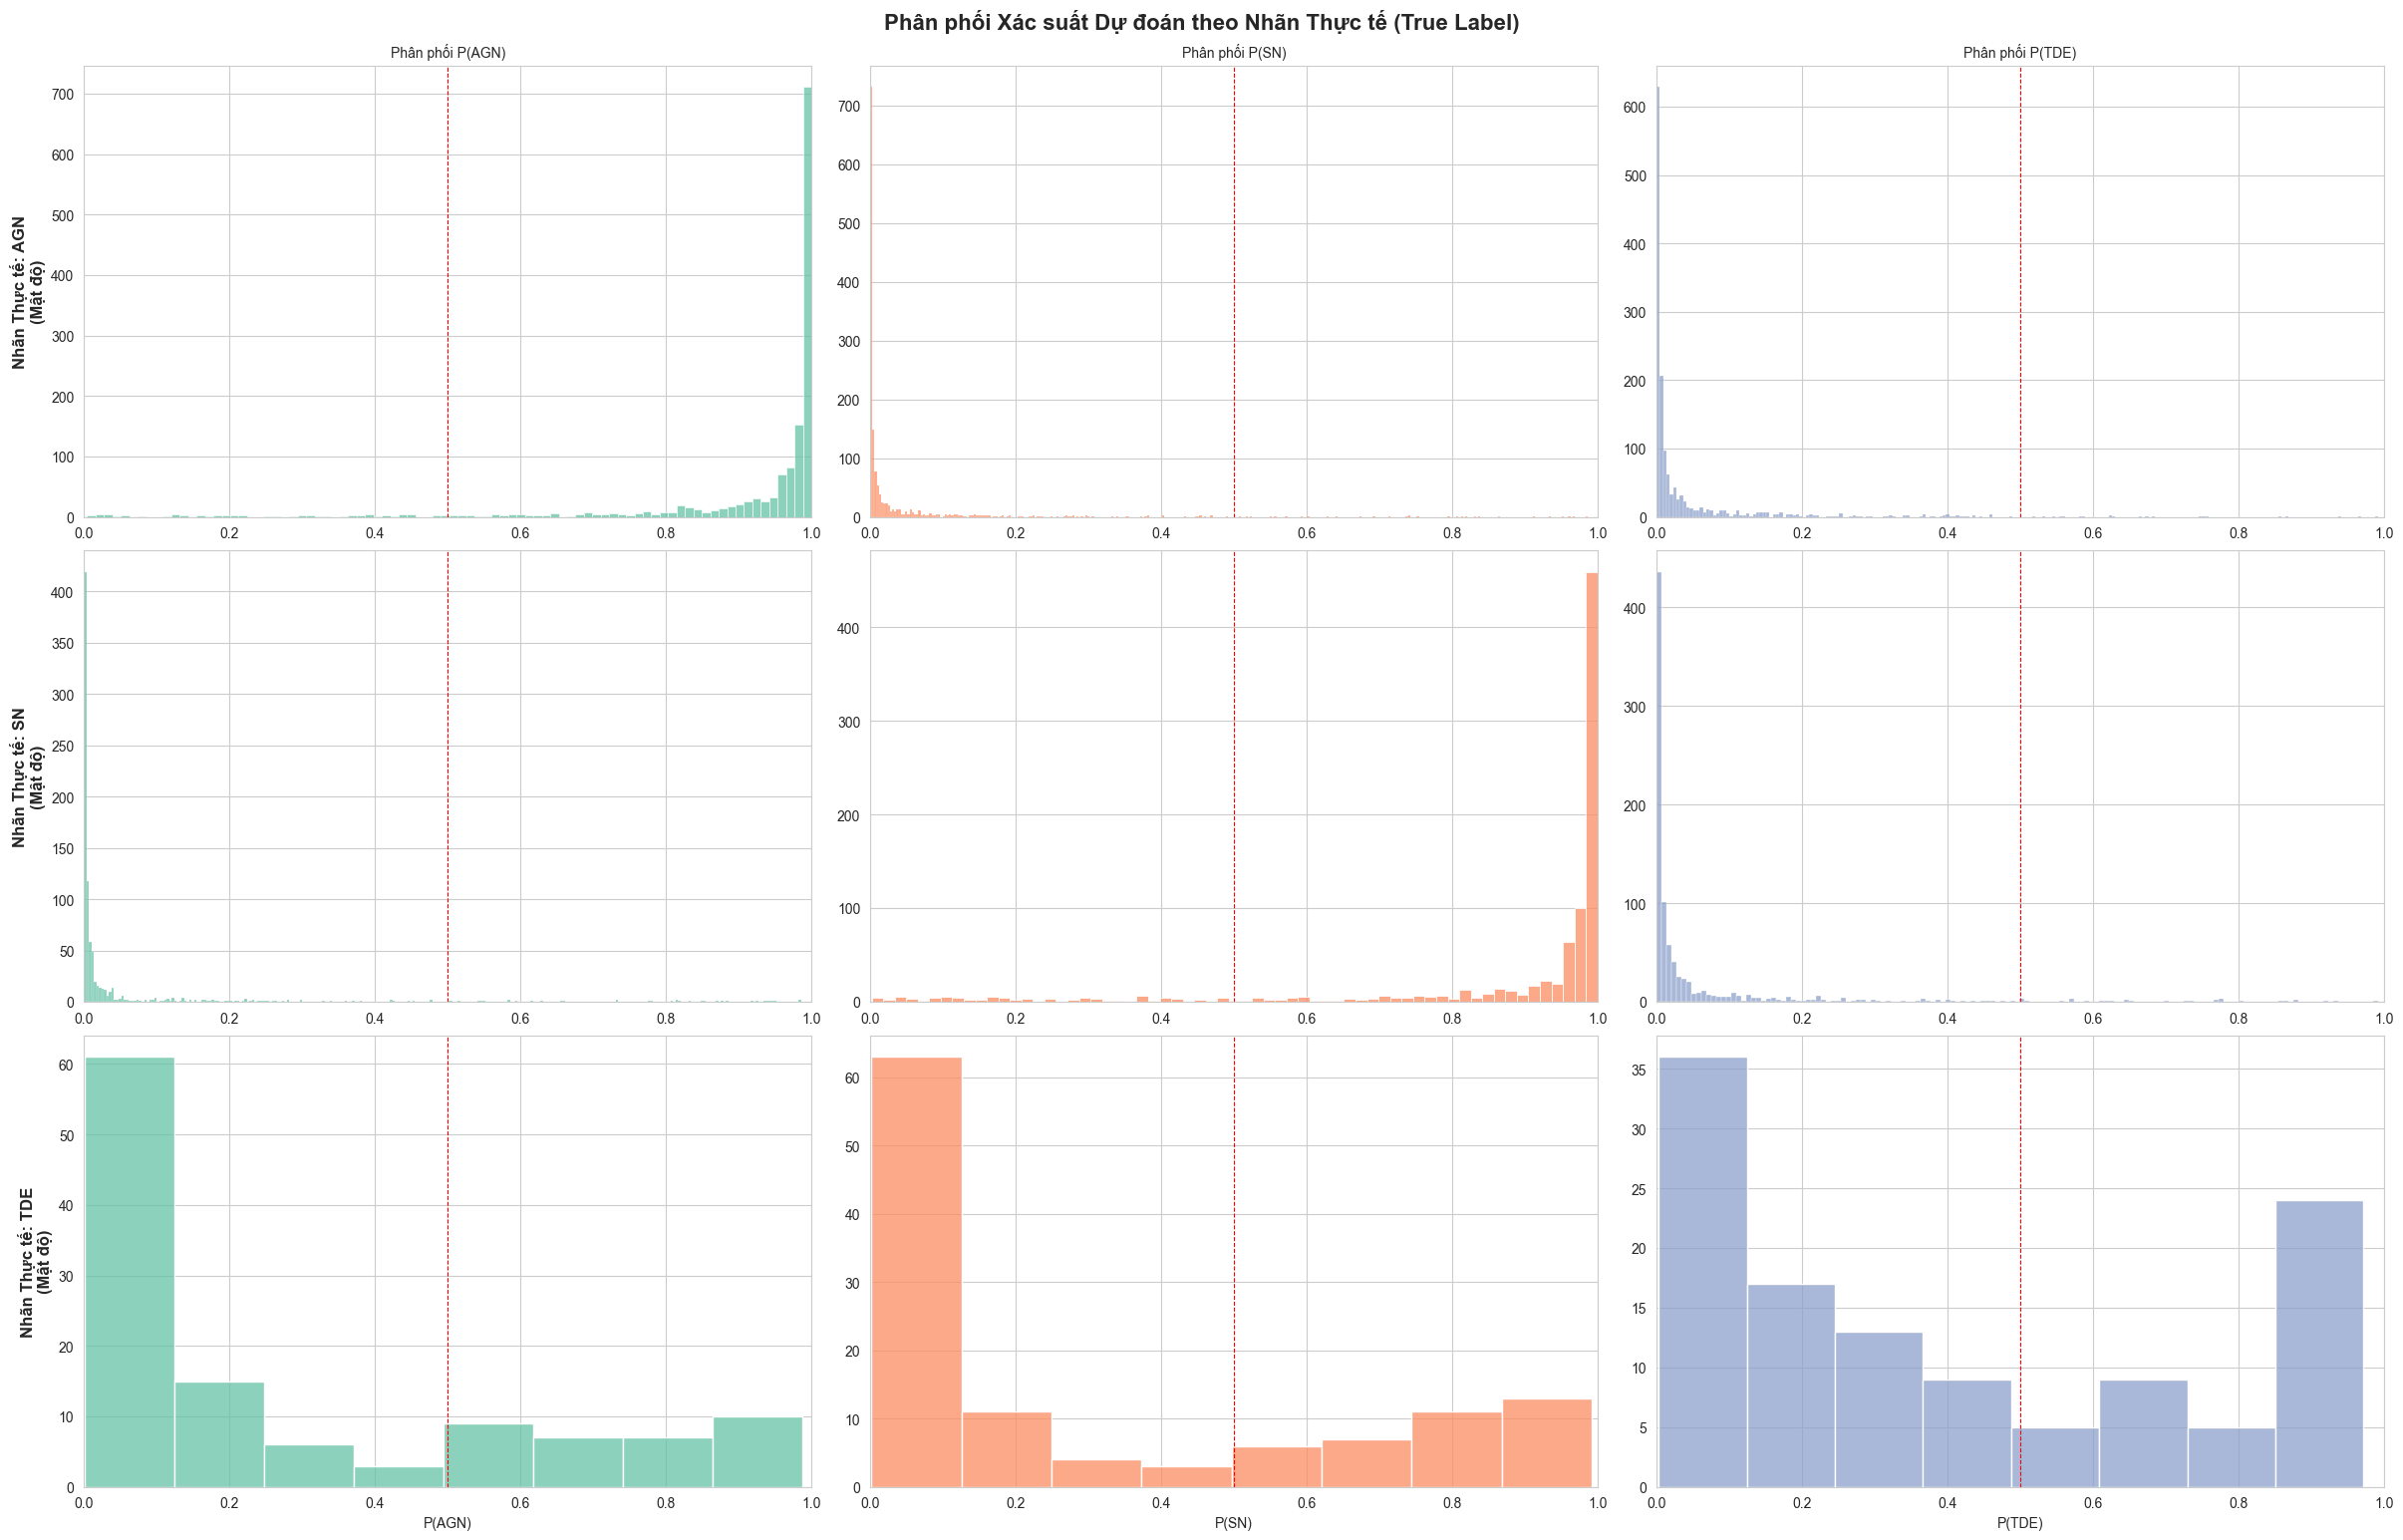

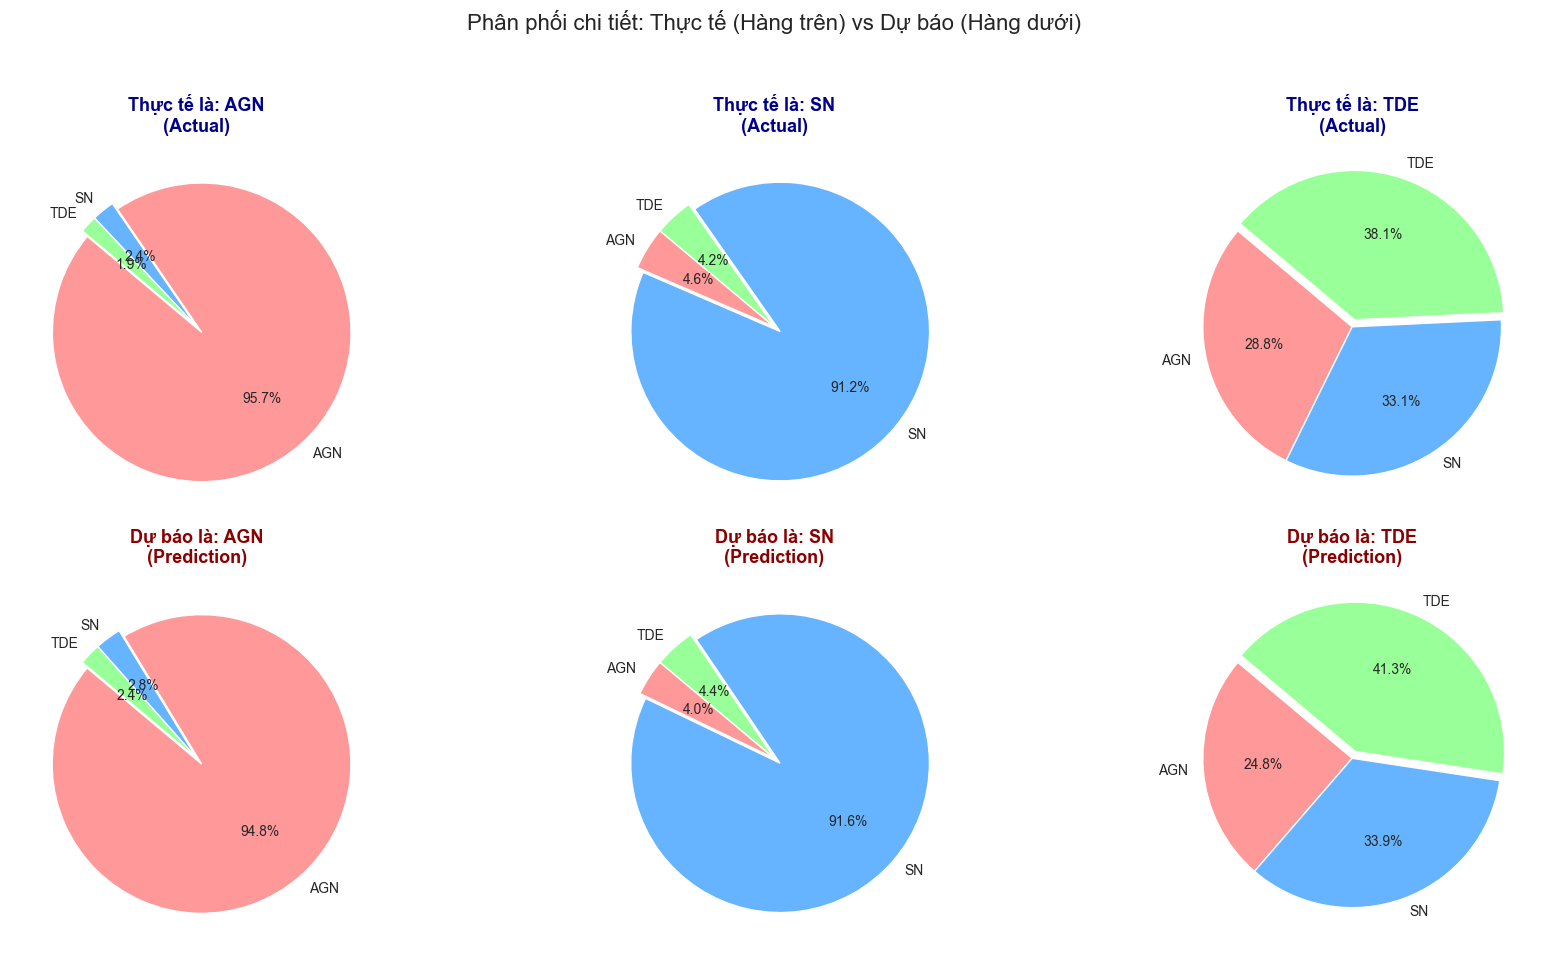

In [69]:
dist = plot_probability_distributions(oof_proba, y_cv, CLASS_NAMES)
plot_prediction_confusion_pie(dist['True Label'], dist['Prediction'])

In [58]:
selector = ( (dist['AGN'] > 0.5) | (dist['SN'] > 0.5) | (dist['TDE'] > 0.5) ) & (dist['Prediction'] != dist['True Label']) & (dist['Prediction'] == 'TDE')

dist[selector].iloc[0:50]

,AGN,SN,TDE,Prediction,True Label
object_id,,,,,
glandagol_aduial_aderthad,0.030547,0.193177,0.776276,TDE,SN
bragol_gwathui_gobennas,0.253886,0.175761,0.570352,TDE,SN
suil_mil_aeglir,0.004574,0.003517,0.991909,TDE,AGN
gli_bain_sirion,0.314557,0.011613,0.673830,TDE,AGN
onodrim_romru_mindon,0.005728,0.293675,0.700596,TDE,SN
inias_ulug_honeg,0.010116,0.220051,0.769832,TDE,SN
iaun_muil_bass,0.020178,0.012388,0.967434,TDE,AGN
ram_lebdas_rist,0.450419,0.015527,0.534054,TDE,AGN
hul_uanui_thamas,0.036516,0.044804,0.918680,TDE,SN


# 5. <a id='toc5_'></a>[Xuất](#toc0_)

In [59]:
# test_log = pd.read_csv(path.join(dirname['root'], 'test_log.csv')).drop(['English Translation'], axis=1)



# test_log_extracted = process_and_combine_splits(
#     test_log,
#     'test_full_lightcurves.csv',
#     full_process
# ).set_index('object_id').drop('SpecType')




# test_proba = np.zeros((len(X_test), lgb_params['num_class']))
# for index, stored in enumerate(models_fold):
#     model, confident = stored
#     confident = [confident[label] for label in CLASS_NAMES]

#     y_proba = model.predict_proba(test_log_extracted)
#     y_prediction = [CLASS_NAMES[i] for i in np.argmax(y_proba, axis=1)]
    
#     test_proba += y_proba / N_SPLITS


# test_predictions = pd.Series([CLASS_NAMES[i] for i in np.argmax(test_proba, axis=1)], index=y_test.index)
# test_predictions